# Shifted Beta-Geometric Modeling with Cohorts

The Shifted Beta-Geometric (sBG) model was first introduced in ["How to Project Customer Retention"](https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_jim_07.pdf) by Hardie & Fader in 2007, and is ideal for predicting customer behavior in business cases involving contract renewals or recurring subscriptions. In this notebook we will reproduce the research results with the cohort and covariate functionality of PyMC-Marketing, then proceed to an end-to-end example with EDA and additional predictive methods. 

##### Tutorial Notebook Outstanding Tasks
- [ ] Fit regular/highend data to both a cohort and covariate model to replicate research results
- [ ] Synthesize data with covariates & multiple time periods to showcase conventional cohort EDA, additional predictive methods, and dropout distribution plotting

In [8]:
import pytensor

#set flag to hotfix open c++ errors
pytensor.config.cxx = '/usr/bin/clang++'

In [9]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from pymc_marketing import clv
import pymc as pm
from pymc_extras.prior import Prior

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
seed = sum(map(ord, "sBG Model"))
rng = np.random.default_rng(seed)

# Load Data

Data must be aggregrated in the following format for model fitting:

- `customer_id` is an index of unique identifiers for each customer
- `recency` indicates the most recent time period a customer was still active
- `T` is the maximum observed time period for a given cohort
- `cohort` indicates the cohort assignment for each customer

For active customers, `recency` is equal to `T`, and all customers in a given cohort share the same value for `T`. If a customer cancelled their contract and restarted at a later date, an additional `customer_id` must be assigned for the restart.

Sample data is available in the PyMC-Marketing repo. To see the code used to generate this data, refer to `generate_sbg_data` in `scripts/clv_data_generation.py`.

In [11]:
cohort_df = pd.read_csv("https://raw.githubusercontent.com/pymc-labs/pymc-marketing/refs/heads/main/data/sbg_cohorts.csv")
cohort_df

,customer_id,recency,T,cohort
0,1,1,8,highend
1,2,1,8,highend
2,3,1,8,highend
3,4,1,8,highend
4,5,1,8,highend
...,...,...,...,...
1995,1996,8,8,regular
1996,1997,8,8,regular
1997,1998,8,8,regular
1998,1999,8,8,regular


This dataset was generated from the first 8 time periods in Table 1 of the research paper, which provides survival rates for two customer cohorts ("Regular" and "Highend") over 13 time periods:

In [12]:
# Data from research paper
research_data = pd.DataFrame(
    {
        "regular": [100.0, 63.1, 46.8, 38.2, 32.6, 28.9, 26.2, 24.1, 22.3, 20.7, 19.4, 18.3, 17.3],
        "highend": [100.0, 86.9, 74.3, 65.3, 59.3, 55.1, 51.7, 49.1, 46.8, 44.5, 42.7, 40.9, 39.4],
    }
)
research_data

,regular,highend
0,100.0,100.0
1,63.1,86.9
2,46.8,74.3
3,38.2,65.3
4,32.6,59.3
5,28.9,55.1
6,26.2,51.7
7,24.1,49.1
8,22.3,46.8
9,20.7,44.5


This is also a useful format for model evaluation. In survival analysis parlance, customers with `recency==T` are "right-censored". If we fit a model to the first 8 time periods, we can test predictions on censored data over the remaining 5 periods:

In [13]:
# Calculate survival percentages for each cohort and time period for testing
def survival_rate_aggregation(customer_df: pd.DataFrame):
    """Aggregate customer-level sBG data into survival rates by cohort over time."""
    # Group by cohort to get total counts
    cohort_totals = customer_df.groupby('cohort')['customer_id'].count()
    cohorts = customer_df["cohort"].unique()
    
    # Create a list to store results for each time period
    results = []
    
    # For each time period from 0 to T (8 in this case)
    for t in range(customer_df['T'].max()):
        row_data = {'T': t}
    
        for cohort in cohorts:
            cohort_data = customer_df[customer_df['cohort'] == cohort]
            total_customers = len(cohort_data)
    
            if t == 0:
                # At time 0, 100% retention
                retention_pct = 100.0
            else:
                # Count customers who survived at least to time t (recency >= t)
                survived = len(cohort_data[cohort_data['recency'] > t])
                retention_pct = (survived / total_customers) * 100
    
            row_data[cohort] = retention_pct
    
        results.append(row_data)

    return pd.DataFrame(results)


df_actual = survival_rate_aggregation(cohort_df)

# Assign T column to research data and truncate to 8 periods
research_data["T"] = research_data.index
df_expected = research_data[["T","highend","regular"]].query("T<8").copy()

# Assert aggregated dataset is equivalent to the values in the research paper
pd.testing.assert_frame_equal(df_actual,df_expected)

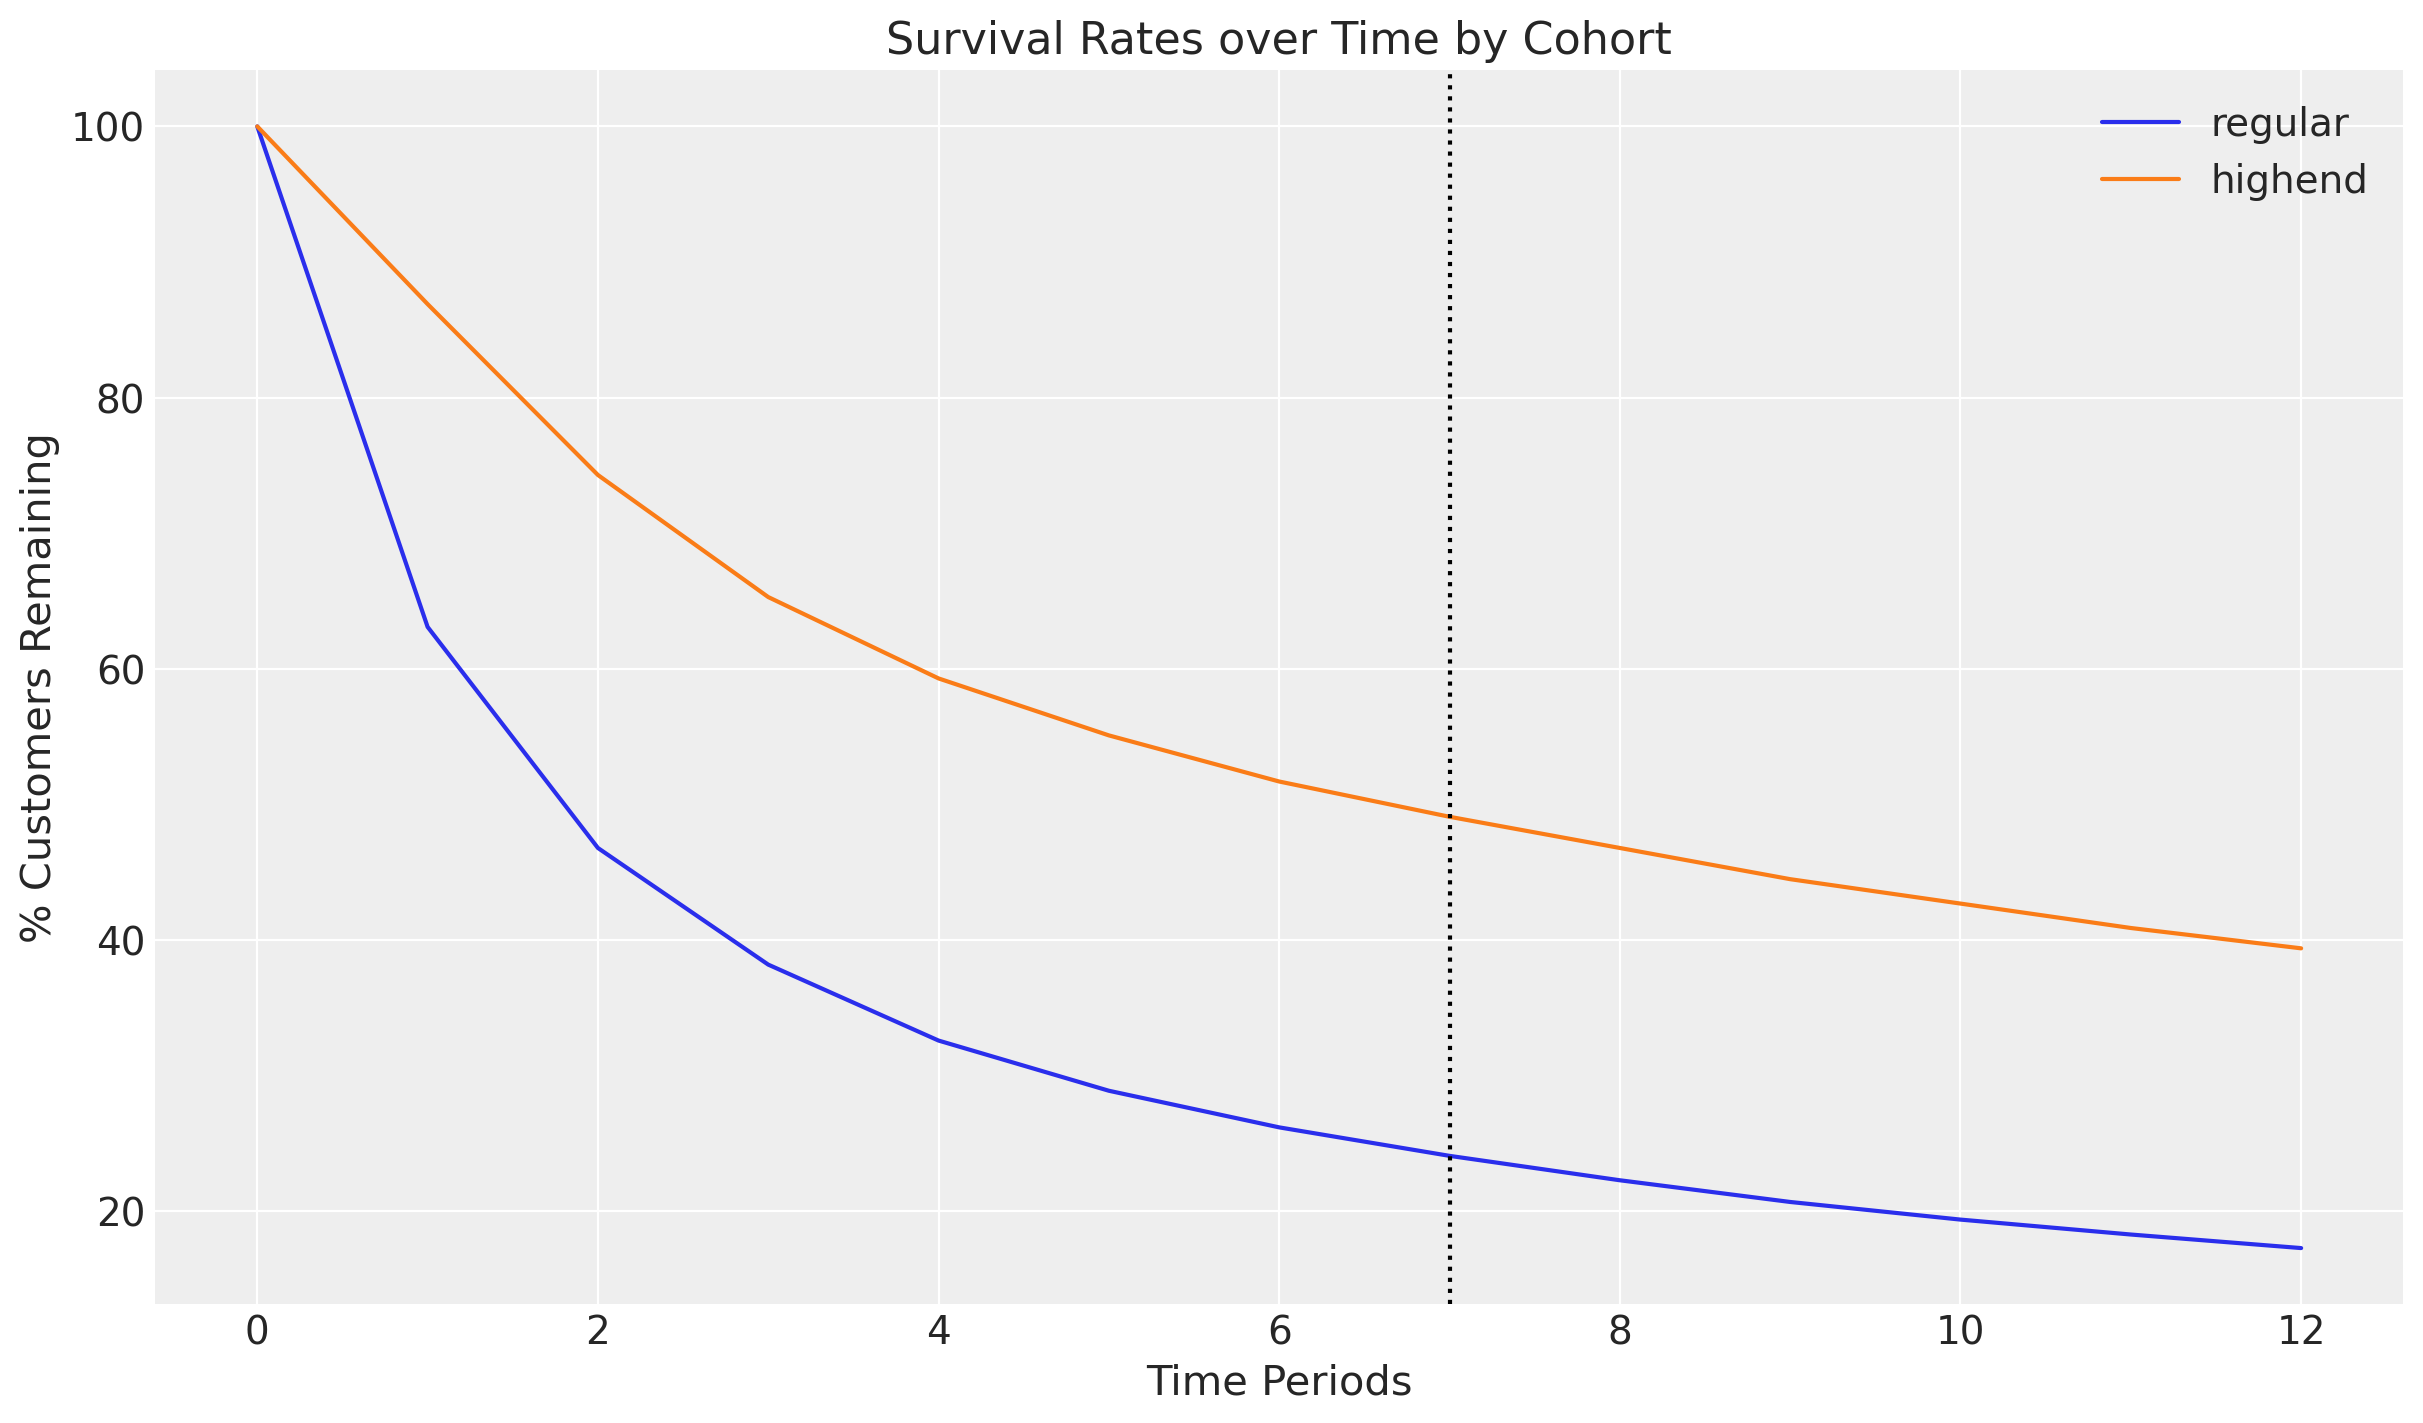

In [14]:
plt.plot(research_data["regular"].values, label="regular")
plt.plot(research_data["highend"].values, label="highend")
plt.legend()
plt.ylabel("% Customers Remaining")
plt.xlabel("Time Periods")
plt.axvline(7, ls=":", color="k")
plt.title("Survival Rates over Time by Cohort");

Let's proceed to the modeling step.

# Model Fitting

The sBG model has the following assumptions:

1. Individual customer lifetime durations are characterized by the (shifted) Geometric distribution, with cancellation probability $\theta$.
2. Heterogeneity in $\theta$ follows a Beta distribution with shape parameters $\alpha$ and $\beta$.

If we take the expectation across the distribution of $\theta$, we can derive a likelihood function to estimate parameters $\alpha$ and $\beta$ for the customer population. For more details on the `ShiftedBetaGeometric` distribution please refer to the [documentation](https://www.pymc-marketing.io/en/latest/api/generated/pymc_marketing.clv.distributions.ShiftedBetaGeometric.html#pymc_marketing.clv.distributions.ShiftedBetaGeometric).

The original frequentist model assumes a single cohort of customers who all started their contracts in the same time period. This would require fitting separate models for each customer cohort. However, in PyMC-Marketing we can fit all cohorts in a single hierarchical Bayesian model!

## Reproduce Research Results with Cohorts

In [15]:
sbg = clv.ShiftedBetaGeoModel(data=cohort_df)
sbg.build_model()
sbg.fit(fit_method='mcmc')
sbg.fit_summary(var_names=["alpha","beta"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, kappa]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[highend],0.667,0.106,0.477,0.863,0.002,0.002,2770.0,2732.0,1.0
alpha[regular],0.704,0.067,0.585,0.832,0.001,0.001,3237.0,2787.0,1.0
beta[highend],3.802,0.805,2.398,5.304,0.017,0.016,2365.0,2373.0,1.0
beta[regular],1.182,0.154,0.899,1.468,0.003,0.003,2450.0,2734.0,1.0


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

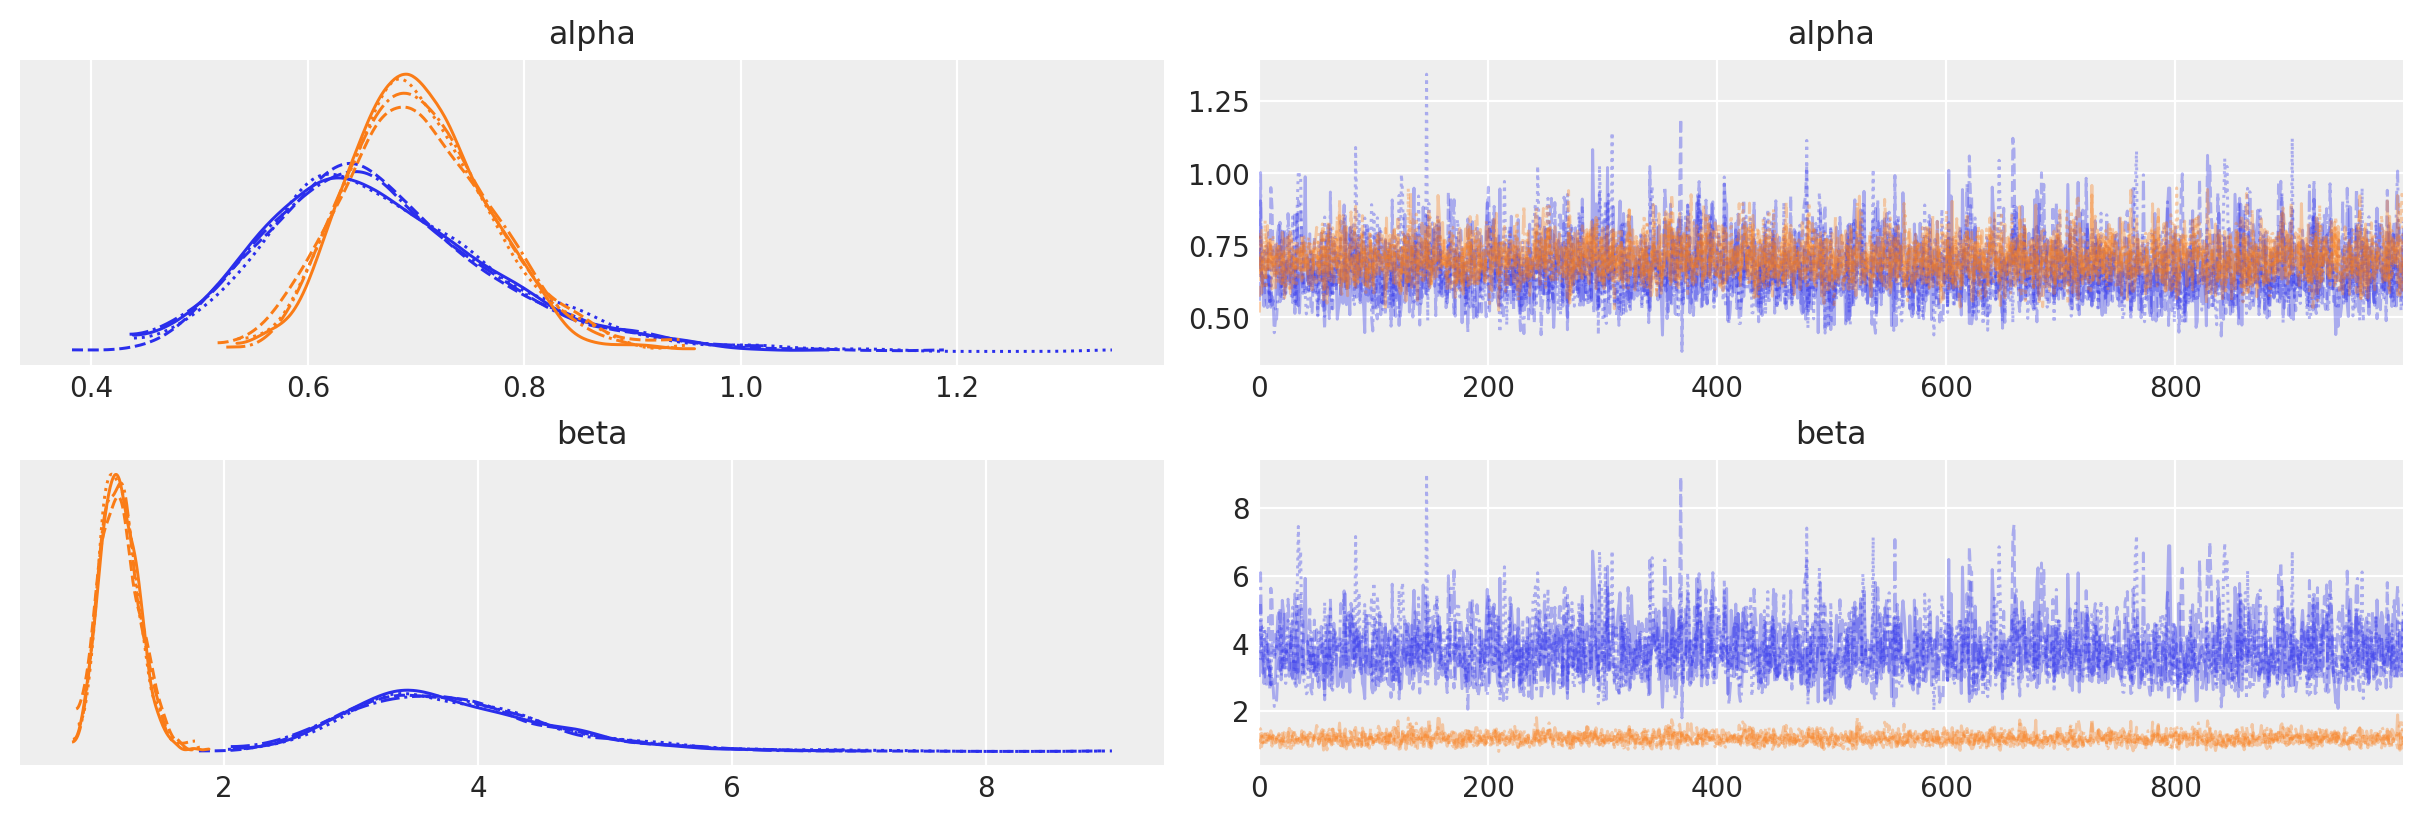

In [16]:
az.plot_trace(sbg.idata,var_names=["alpha","beta"])

Below cell is a WIP for plotting a time period trend for model evaluation for Probability Alive.

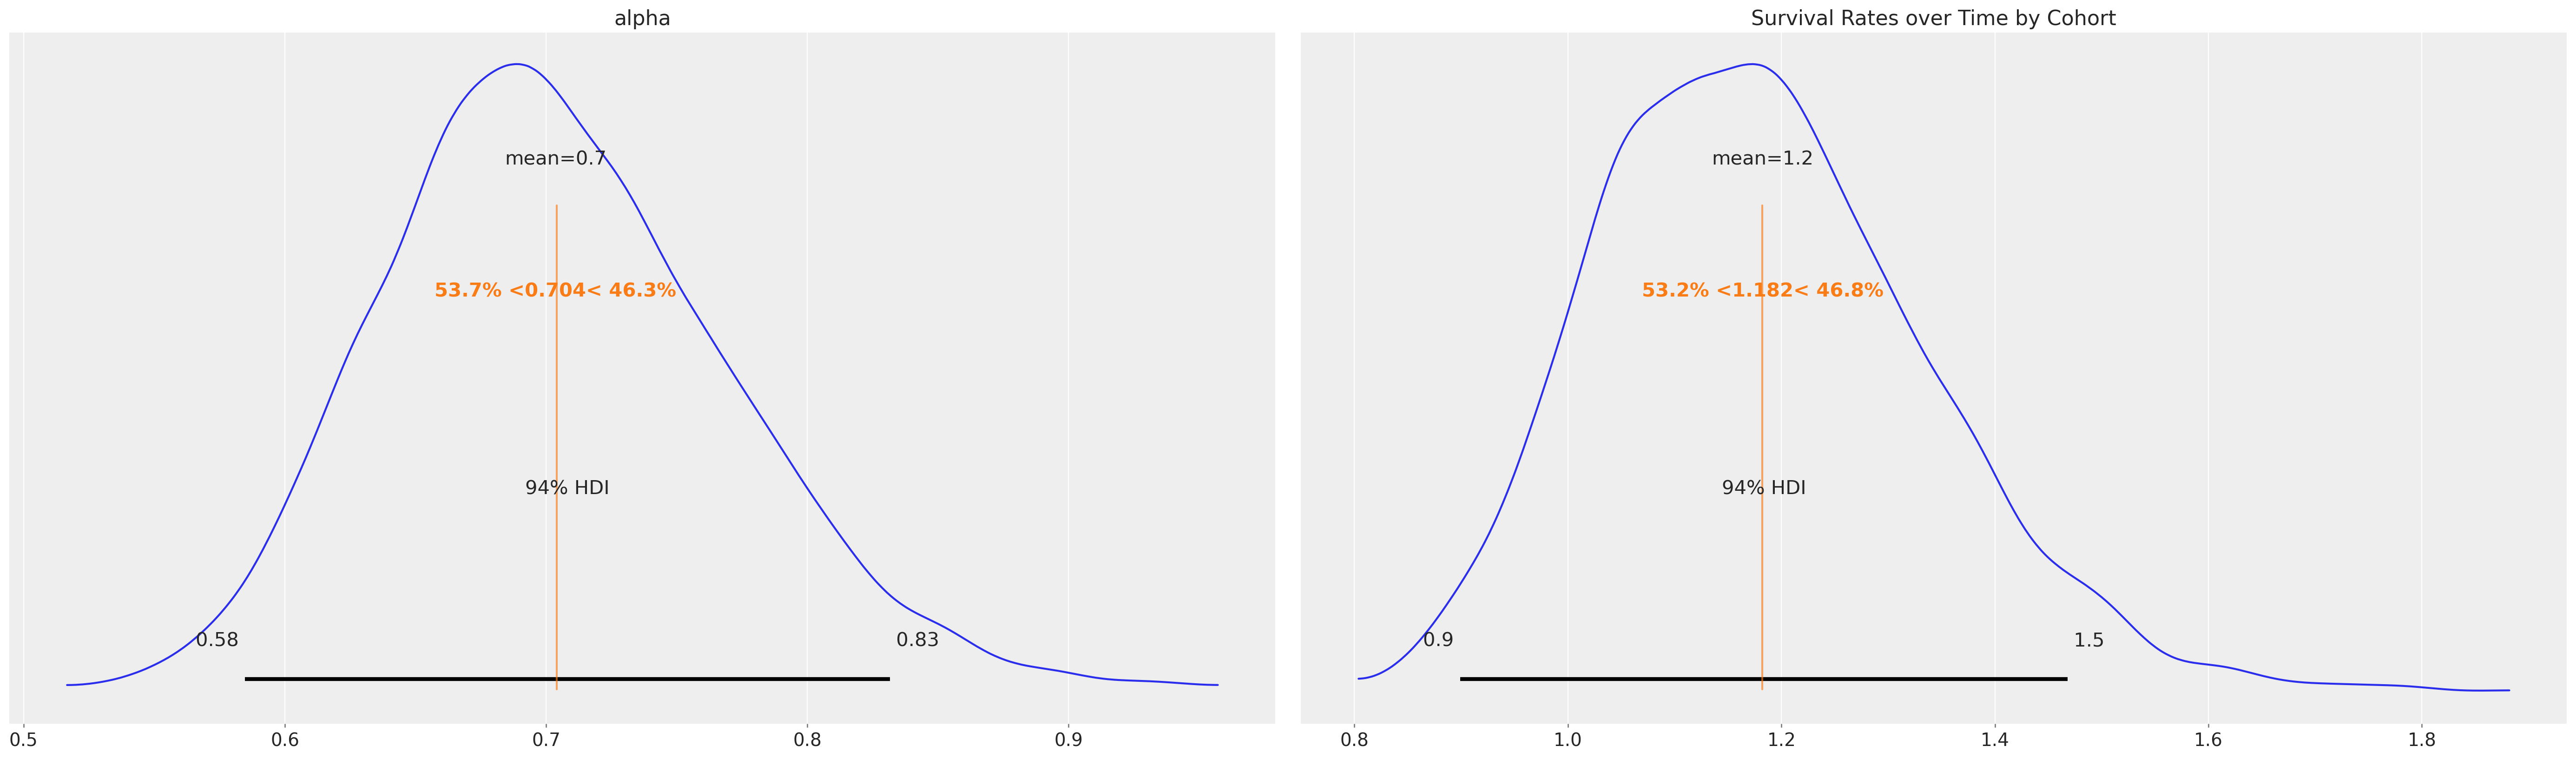

In [22]:
# MLE estimates from the paper
ref_val = {
    "highend": [0.668, 3.806],
    "regular": [0.704, 1.182],
}
# Map cohort-wise [alpha, beta] refs to ArviZ variable labels
ref_val_map = {}
for cohort, (a_ref, b_ref) in ref_val.items():
    ref_val_map[f"alpha\n{cohort}"] = a_ref
    ref_val_map[f"beta\n{cohort}"]  = b_ref
   
az.plot_posterior(
    sbg.idata.sel(cohort="regular"),
    var_names=["alpha", "beta"],
    ref_val=ref_val["regular"],
)
plt.title("Survival Rates over Time by Cohort");

In [33]:
max_T = 12
fit_T = 8
np.arange(fit_T * -1, max_T-fit_T,1)

array([-8, -7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3])

In [77]:
expected_survival_rates = xr.concat(
    objs=[
        sbg.expected_probability_alive(
            future_t=t,
        )
        for t in np.arange(fit_T * -1, max_T-fit_T+1,1)
    ],
    dim="t",
).transpose(..., "t")

# unique_cohorts = np.unique(expected_purchases_over_time.coords["cohort"].values)

# for cohort in unique_cohorts:
#     print(expected_purchases_over_time.sel(cohort=cohort).mean("t"))

<Axes: >

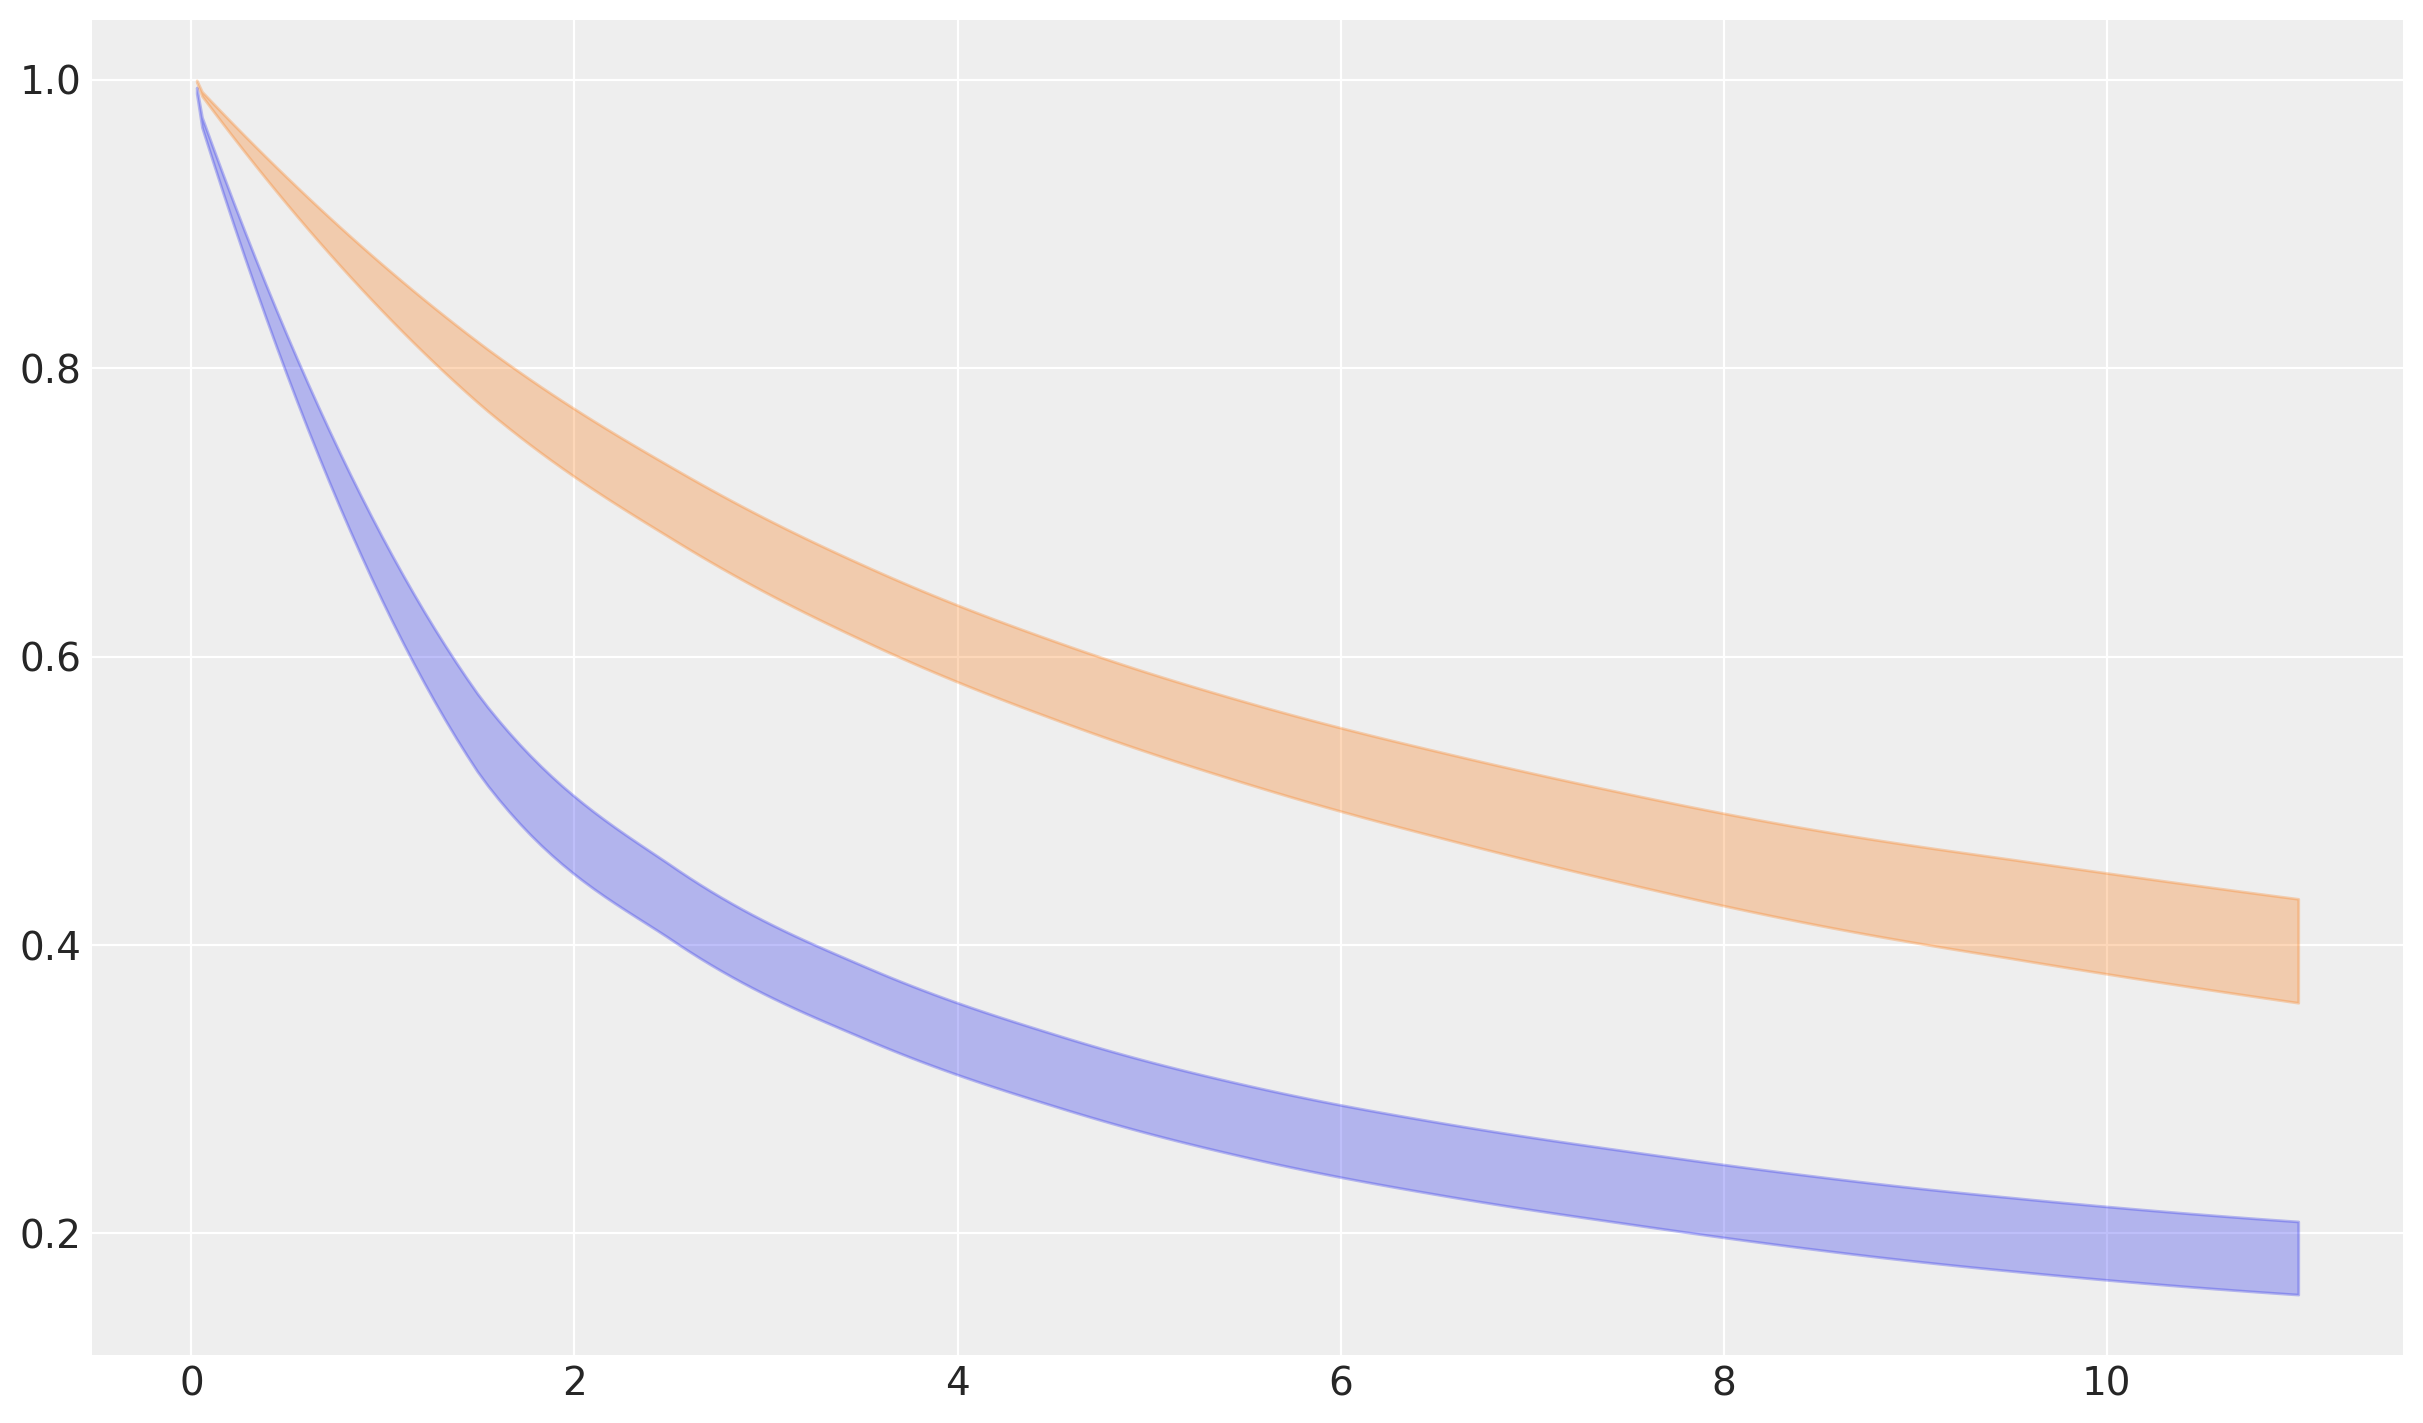

In [48]:
az.plot_hdi(
        range(max_T),
        expected_survival_rates.sel(cohort="regular").mean("cohort"),
        hdi_prob=0.94,
        color="C0",
        fill_kwargs={"alpha": 0.3, "label": "$94 \\%$ HDI"},
        #ax=ax,
    )
az.plot_hdi(
        range(max_T),
        expected_survival_rates.sel(cohort="highend").mean("cohort"),
        hdi_prob=0.94,
        color="C1",
        fill_kwargs={"alpha": 0.3, "label": "$94 \\%$ HDI"},
        #ax=ax,
    )
plt.plot(range(max_T+1), research_data["highend"]/100, color="k", label="observed")
plt.plot(range(max_T+1), research_data["regular"]/100, color="k")

## Quick Covariate Example

In this particular dataset, both cohorts could also be indicated as a simple binary covariate since they start in the same time period:

In [49]:
# create a covariate column to identify highend customers
cohort_df["highend_customer"] = np.where(cohort_df["cohort"] == "highend", 1, 0)
# modify cohort column for a single "population" cohort
covariate_df = cohort_df.assign(cohort="population")
covariate_df

,customer_id,recency,T,cohort,highend_customer
0,1,1,8,population,1
1,2,1,8,population,1
2,3,1,8,population,1
3,4,1,8,population,1
4,5,1,8,population,1
...,...,...,...,...,...
1995,1996,8,8,population,0
1996,1997,8,8,population,0
1997,1998,8,8,population,0
1998,1999,8,8,population,0


Model fitting takes more time with MCMC with covariates compared to cohorts. A gradient-free sampler like [`DEMetropolisZ`](https://www.pymc.io/projects/docs/en/v5.6.1/api/generated/pymc.DEMetropolisZ.html) will converge in less time. If it gets stuck due to posterior geometry, use MAP fits instead.

In [52]:
sbg = clv.ShiftedBetaGeoModel(
    data=covariate_df,
        model_config = {
        "dropout_covariate_cols": ["highend_customer"],
    }
)
sbg.build_model()
sbg.fit(fit_method='demz',tune=3000, draws=3000) #'demz' needs a lot of tunes/draws
sbg.fit_summary(var_names=["alpha","beta"])
# thin fit result to reduce model size
sbg.thin_fit_result(keep_every=2)

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [phi, kappa, dropout_coefficient_alpha, dropout_coefficient_beta]


Output()

Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 4 seconds.


Shifted Beta-Geometric
                      phi ~ Uniform(0, 1)
                    kappa ~ Pareto(1, 1)
dropout_coefficient_alpha ~ Normal(0, 1)
 dropout_coefficient_beta ~ Normal(0, 1)
              alpha_scale ~ Deterministic(f(kappa, phi))
               beta_scale ~ Deterministic(f(kappa, phi))
                    alpha ~ Deterministic(f(dropout_coefficient_alpha, kappa, phi))
                     beta ~ Deterministic(f(dropout_coefficient_beta, kappa, phi))
                  dropout ~ Censored(ShiftedBetaGeometric(alpha, beta), -inf, <constant>)

array([[<Axes: title={'center': 'alpha_scale'}>,
        <Axes: title={'center': 'alpha_scale'}>],
       [<Axes: title={'center': 'beta_scale'}>,
        <Axes: title={'center': 'beta_scale'}>],
       [<Axes: title={'center': 'dropout_coefficient_alpha'}>,
        <Axes: title={'center': 'dropout_coefficient_alpha'}>],
       [<Axes: title={'center': 'dropout_coefficient_beta'}>,
        <Axes: title={'center': 'dropout_coefficient_beta'}>]],
      dtype=object)

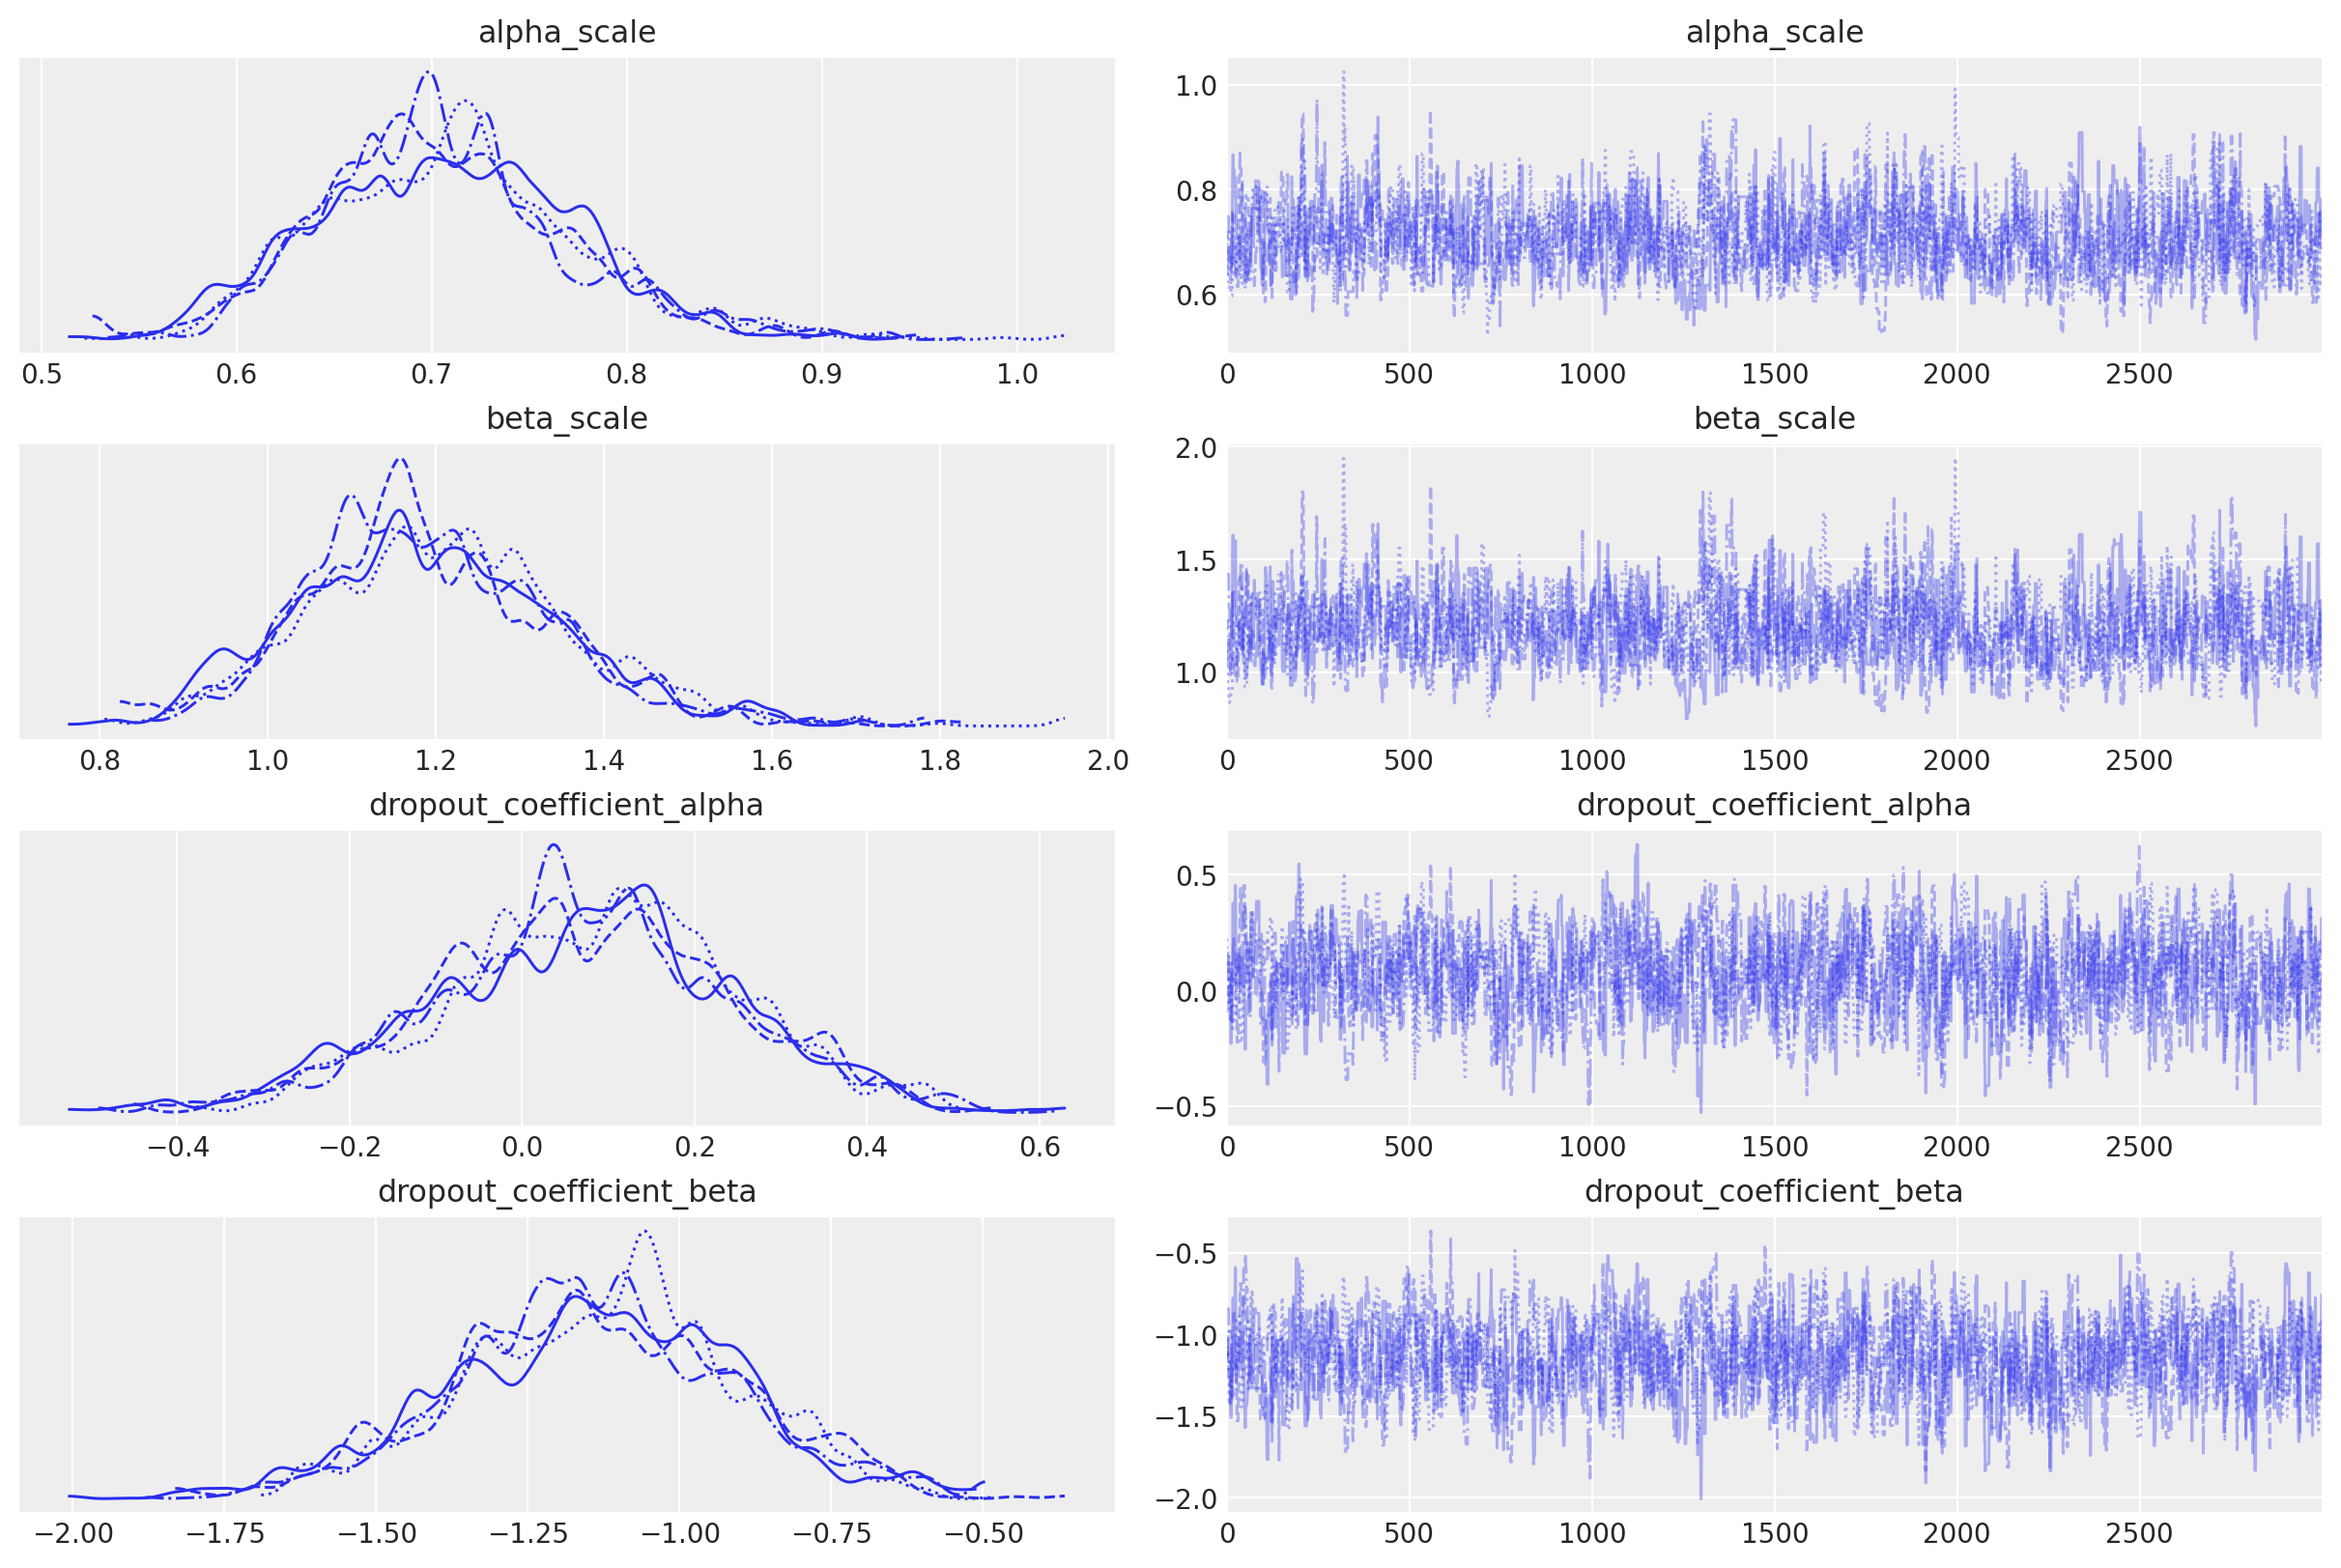

In [53]:
az.plot_trace(sbg.idata,var_names=["alpha_scale","beta_scale", "dropout_coefficient_alpha", "dropout_coefficient_beta"])

In [75]:
highend = covariate_df.query("highend_customer==1 & recency==T").copy()
regular = covariate_df.query("highend_customer==0 & recency==T").copy()

expected_survival_rates_hi = xr.concat(
    objs=[
        sbg.expected_probability_alive(
            data=highend,
            future_t=t,
        )
        for t in np.arange(fit_T * -1, max_T-fit_T+1,1)
    ],
    dim="t",
).transpose(..., "t")

expected_survival_rates_reg = xr.concat(
    objs=[
        sbg.expected_probability_alive(
            data=regular,
            future_t=t,
        )
        for t in np.arange(fit_T * -1, max_T-fit_T+1,1)
    ],
    dim="t",
).transpose(..., "t")

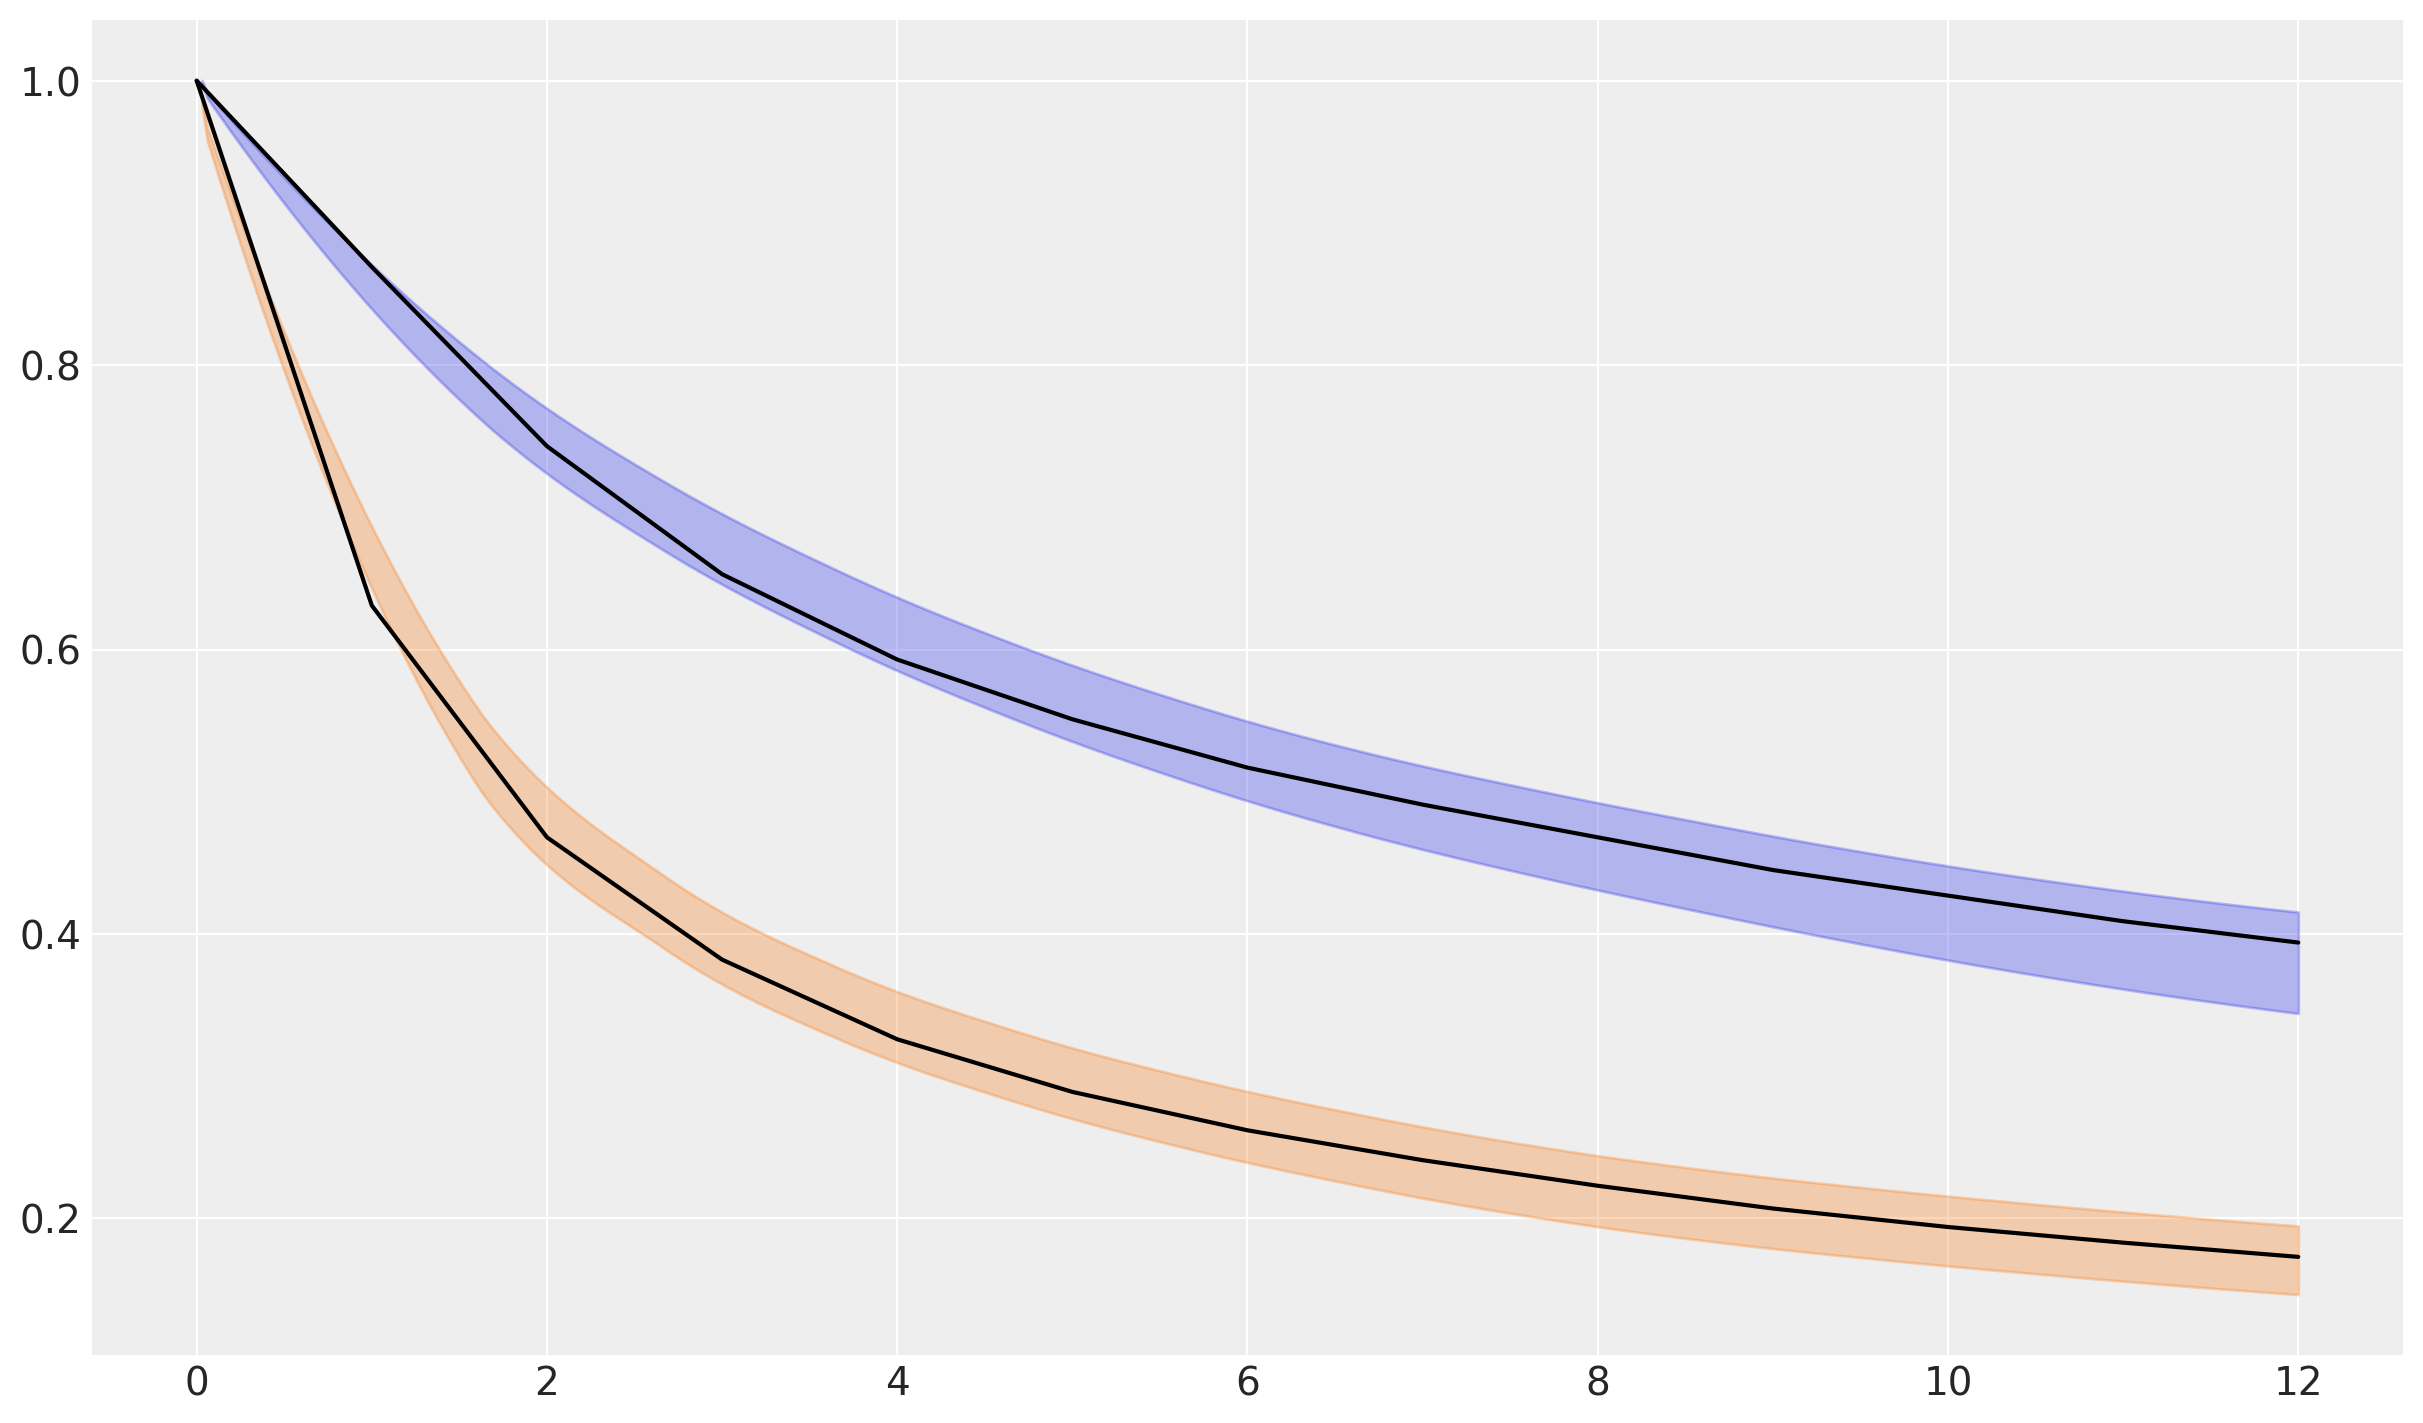

In [76]:
az.plot_hdi(
        range(max_T+1),
        expected_survival_rates_hi.mean("cohort"),
        hdi_prob=0.94,
        color="C0",
        fill_kwargs={"alpha": 0.3, "label": "$94 \\%$ HDI"},
        #ax=ax,
    )
az.plot_hdi(
        range(max_T+1),
        expected_survival_rates_reg.mean("cohort"),
        hdi_prob=0.94,
        color="C1",
        fill_kwargs={"alpha": 0.3, "label": "$94 \\%$ HDI"},
        #ax=ax,
    )

plt.plot(range(max_T+1), research_data["highend"]/100, color="k", label="observed")
plt.plot(range(max_T+1), research_data["regular"]/100, color="k")

## Contrasting posterior inferences with the repo MLE estimates

The sBG model has 2 population parameters of interest: `alpha` and `beta`. 
These parameters define the population distribution of the latent churn rate distribution `theta`. 
The larger the values of `alpha` and `beta`, the more homogenous the churn rates across different customers. 

The ratio of `alpha` to `beta` tells us the expected churn rates. If `alpha/beta == 0.1`, we expect the average customer to have a `0.1` probability of churning between each time period.

The model fitting agrees with the Maximum Likelihood estimates described in the original paper.
In addition, MCMC sampling, gives us useful information about the uncertainty of the fits.

**Below plotting code cells were lifted directly from sBG-Individual notebook and require adaptation:**

In [29]:
# obs = df["highend"]/100

# plt.plot(survive_pred,color="b", label="predicted")
# plt.plot(obs,color="k", label="observed")
# plt.ylabel("Survival Rate")
# plt.legend()
# plt.title("High-End Customers MAP")

# plt.plot(reg_retention_cohort[:8],color="b", label="predicted")
# plt.plot(retention_rate_regular_obs[:8],color="k", label="observed")
# plt.ylabel("Retention Rate")
# plt.legend()
# plt.title("Regular Customers MCMC Estimated with Cohorts")

Figures 4 and 5 show the predicted average churn and retention trends for the two groups.
We can see that predictions nicely match the observed data (black line), even when extrapolating into the time periods that were held-out when fitting the model.

The plots also highlight an interesting implication from the model: 
the retention rates are expected to increase over time, as the more precarious customers gradually drop out. This is a direct consequence of modelling individual churn rates as being fixed over time.

In [30]:
# az.plot_hdi(
#     weeks_,
#     hi_retention.mean("customer_id"),
#     hdi_prob=0.95,
#     color="C0",
#     fill_kwargs={"label": "high end"},
# )
# az.plot_hdi(
#     weeks_,
#     lo_retention.mean("customer_id"),
#     hdi_prob=0.95,
#     color="C1",
#     fill_kwargs={"label": "regular"},
# )

# plt.plot(weeks_, retention_rate_highend_obs, color="k", label="observed")
# plt.plot(weeks_, retention_rate_regular_obs, color="k")

# plt.axvline(7, ls="--", color="k")
# plt.ylim([0.5, 1.05])
# plt.ylabel("Retention Rate")
# plt.legend()
# plt.title("Figure 5");

In [60]:
# filter dataset to only active customers
pred_data=dataset.query("recency==T")

# predict retention rate and convert to dataframe for downstream processing
pred_cohort_retention = sbg.expected_retention_rate(pred_data,future_t=0).mean(("chain","draw"))
pred_cohort_retention.to_dataframe(name="retention").reset_index()

,cohort,customer_id,retention
0,highend,510,0.942107
1,highend,511,0.942107
2,highend,512,0.942107
3,highend,513,0.942107
4,highend,514,0.942107
...,...,...,...
727,regular,1996,0.920621
728,regular,1997,0.920621
729,regular,1998,0.920621
730,regular,1999,0.920621


## Full Example with Cohorts and Covariates

Now let's create a full example with both cohorts and covariates:

In [46]:
# Generate 12 monthly cohorts with shifted observation periods
cohort_dfs = []

for month in range(1, 13):
    # Calculate observation period: January (month 1) has 12 periods, December (month 12) has 1 period
    observation_periods = 13 - month
    month_cohort_name = f"2025-{month:02d}"
    
    # Add the time-based cohort (month they joined)
    monthly_cohort_df = covariate_df.copy()
    monthly_cohort_df["cohort"] = month_cohort_name
    
    cohort_dfs.append(monthly_cohort_df)

# Combine all monthly cohorts
monthly_cohort_dataset = pd.concat(cohort_dfs, ignore_index=True)

# Recreate customer_id to be unique across all cohorts
monthly_cohort_dataset["customer_id"] = monthly_cohort_dataset.index + 1

# # Add the highend_customer indicator based on customer_segment
# monthly_cohort_dataset["highend_customer"] = np.where(
#     monthly_cohort_dataset["customer_segment"] == "highend", 
#     1, 
#     0
# )

# Reorder columns for clarity
monthly_cohort_dataset = monthly_cohort_dataset[[
    'customer_id', 'recency', 'T', 'cohort', 'highend_customer', 
]]

# Display summary
print(f"Total customers: {len(monthly_cohort_dataset):,}")
print(f"\nMonthly cohorts: {sorted(monthly_cohort_dataset['cohort'].unique())}")

Total customers: 24,000

Monthly cohorts: ['2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07', '2025-08', '2025-09', '2025-10', '2025-11', '2025-12']


In [50]:
retention_df = retention_rate_aggregation(monthly_cohort_dataset)
retention_df

,T,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07,2025-08,2025-09,2025-10,2025-11,2025-12
0,0,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
1,1,75.00,75.00,75.00,75.00,75.00,75.00,75.00,75.00,75.00,75.00,75.00,75.00
2,2,60.55,60.55,60.55,60.55,60.55,60.55,60.55,60.55,60.55,60.55,60.55,60.55
3,3,51.75,51.75,51.75,51.75,51.75,51.75,51.75,51.75,51.75,51.75,51.75,51.75
4,4,45.95,45.95,45.95,45.95,45.95,45.95,45.95,45.95,45.95,45.95,45.95,45.95
5,5,42.00,42.00,42.00,42.00,42.00,42.00,42.00,42.00,42.00,42.00,42.00,42.00
6,6,38.95,38.95,38.95,38.95,38.95,38.95,38.95,38.95,38.95,38.95,38.95,38.95
7,7,36.60,36.60,36.60,36.60,36.60,36.60,36.60,36.60,36.60,36.60,36.60,36.60


/var/folders/fg/0gjlwtr11dd51xt6hkb8qw6h0000gn/T/ipykernel_64517/1789314211.py:73: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


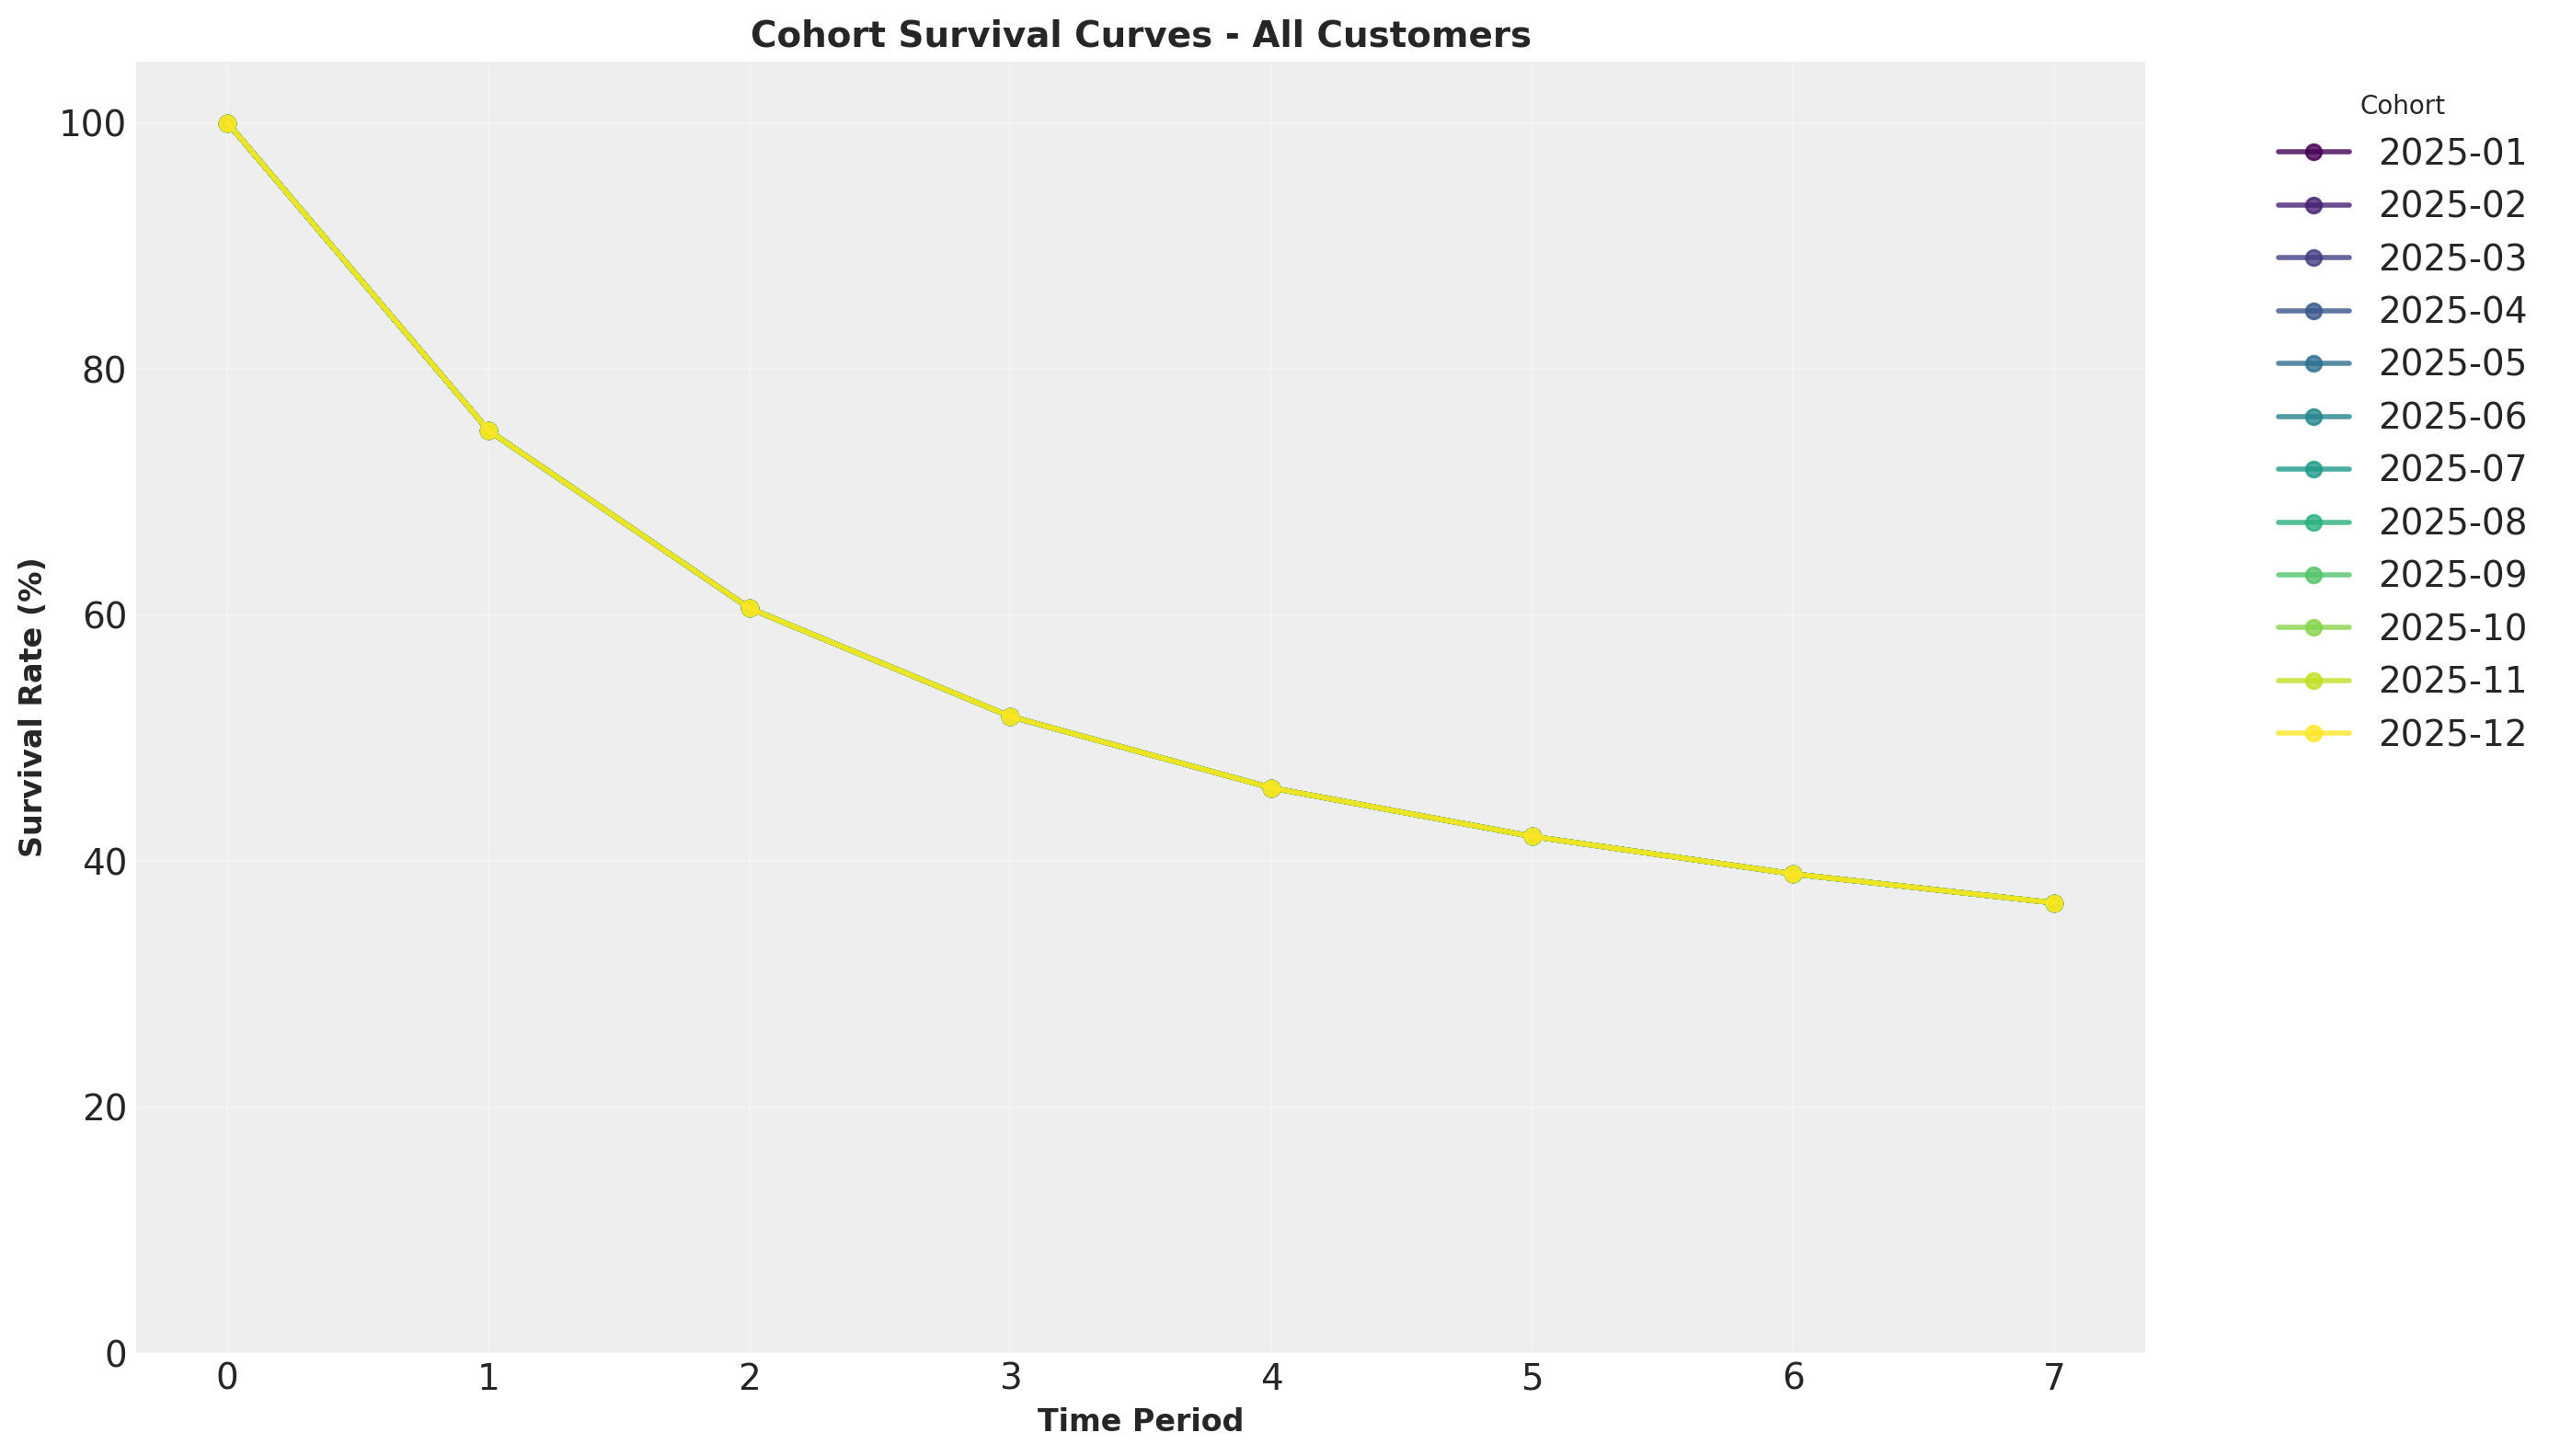

RuntimeError: Colorbar layout of new layout engine not compatible with old engine, and a colorbar has been created.  Engine not changed.

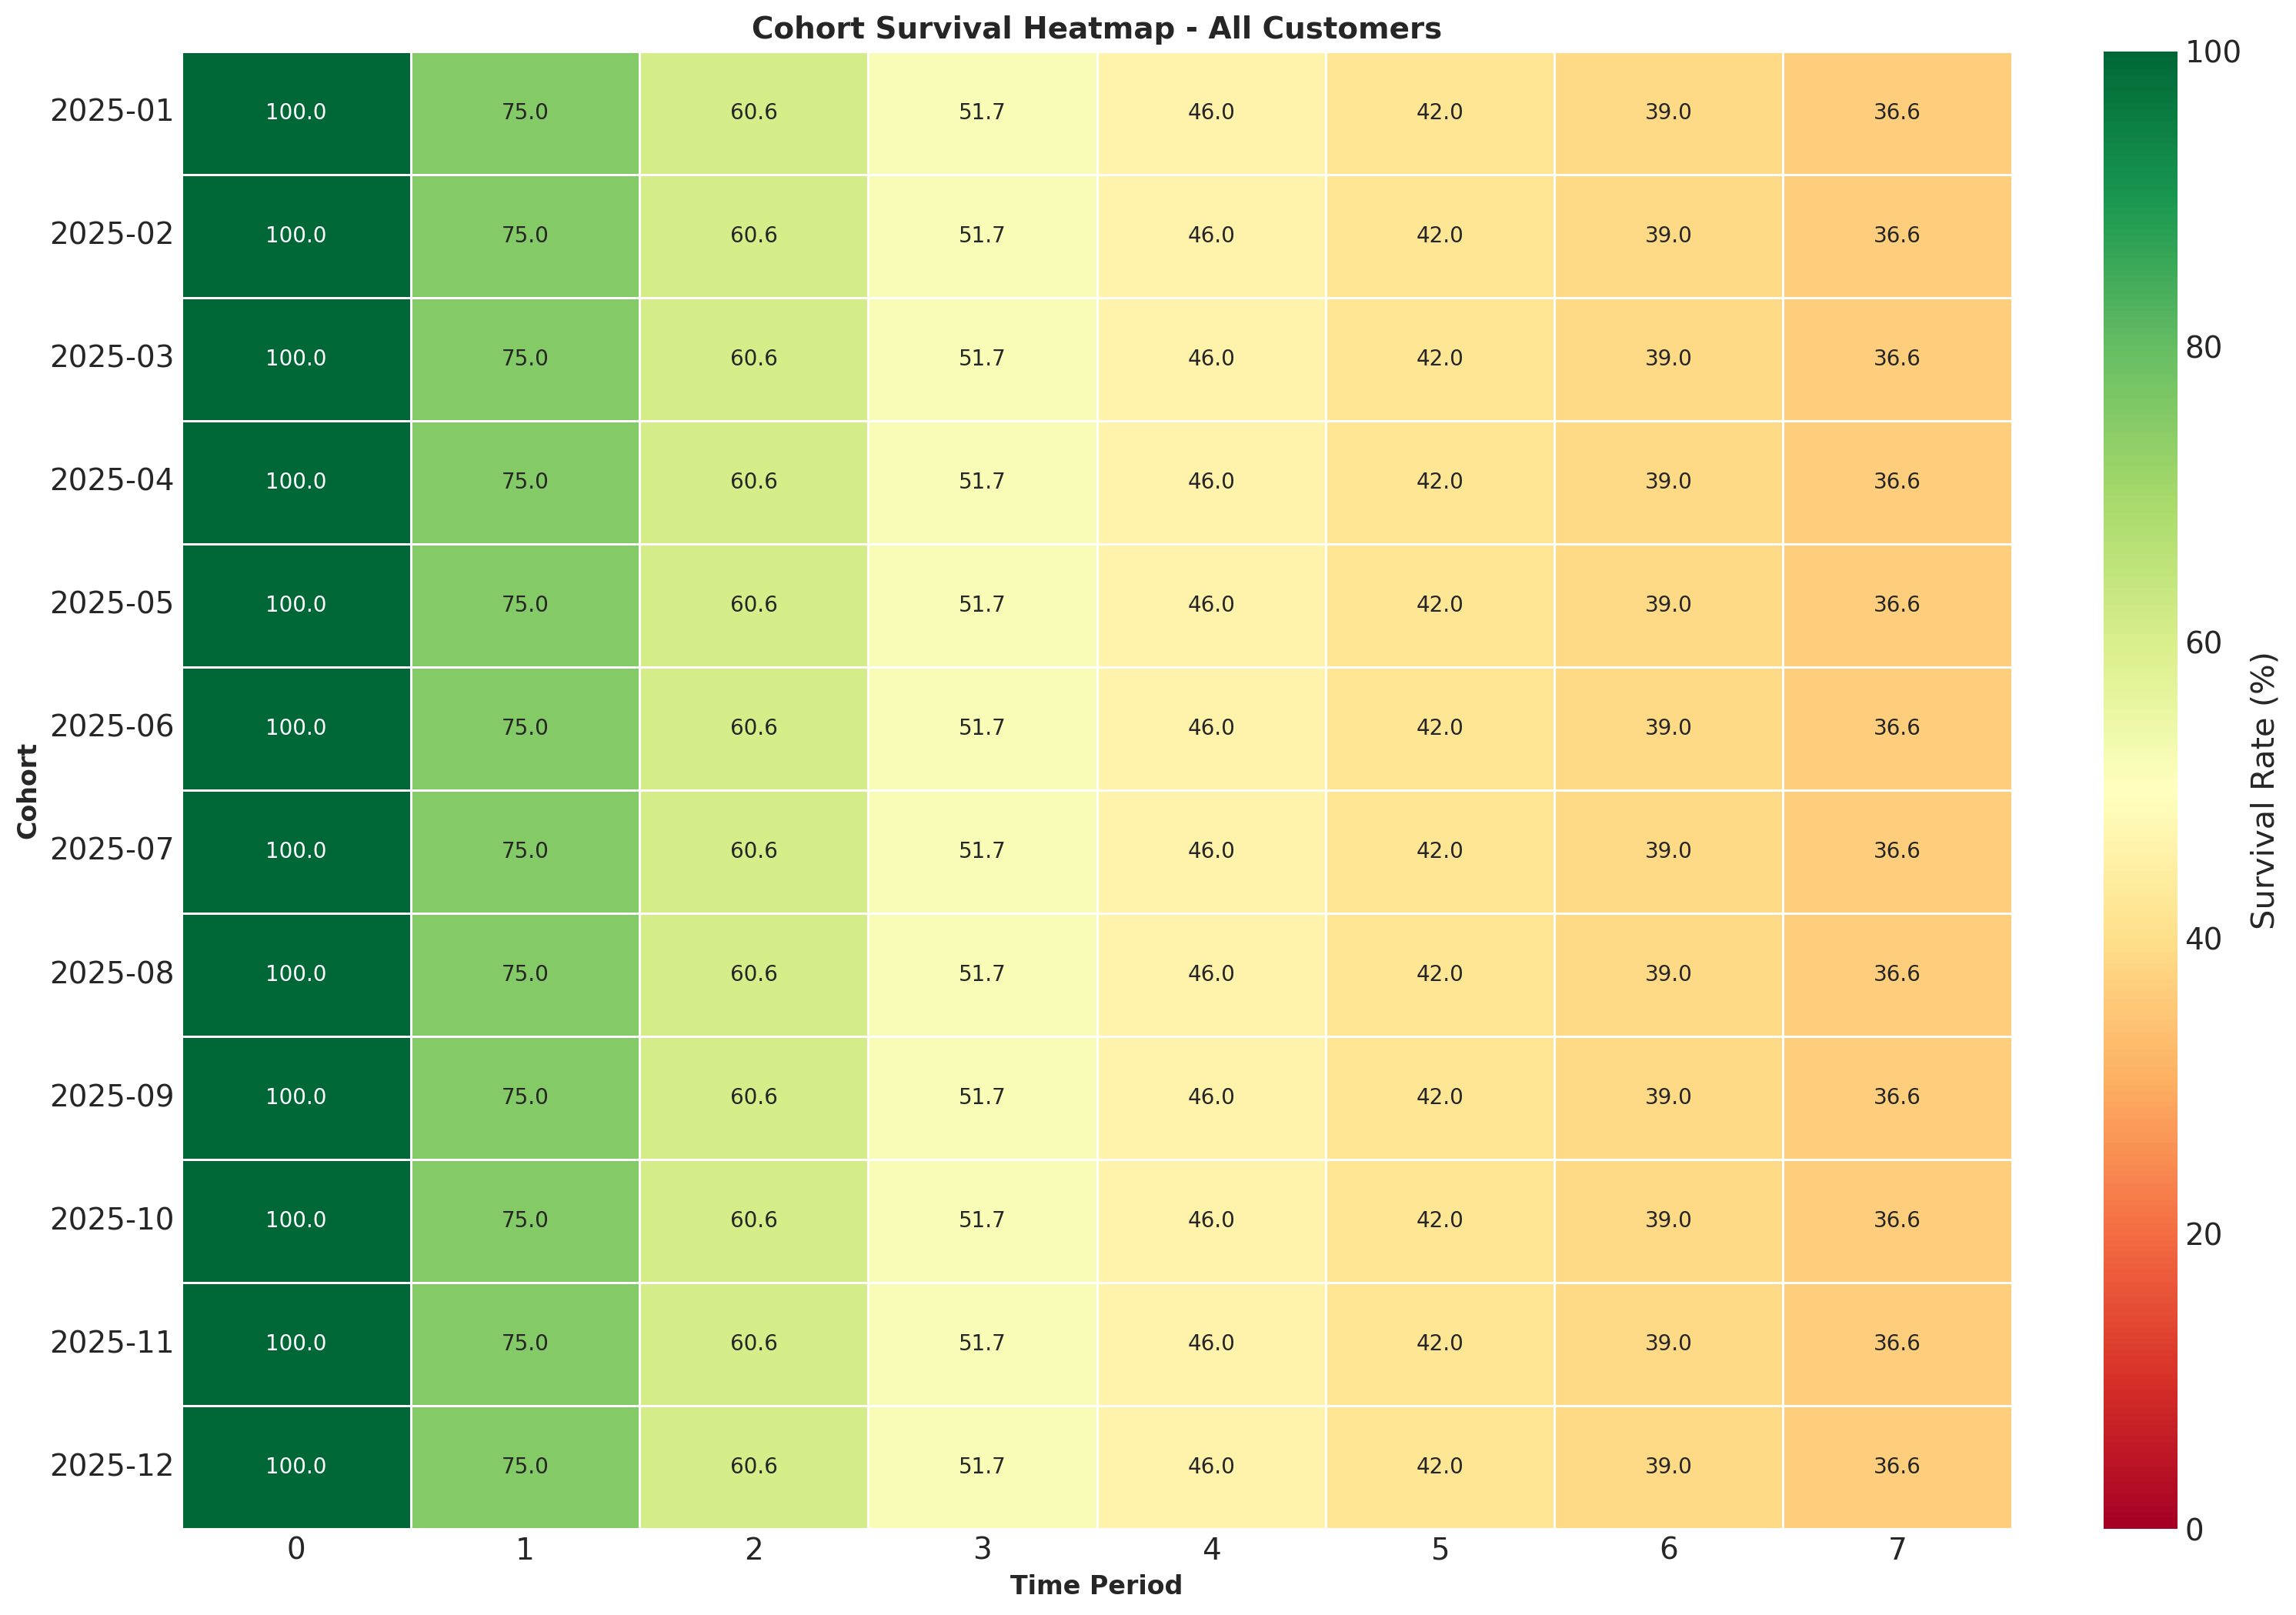

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# # Use the provided survival_rate_aggregation function
# def survival_rate_aggregation(customer_df: pd.DataFrame):
#     """Aggregate customer-level sBG data into survival rates by cohort over time for model testing."""
#     # Group by cohort to get total counts
#     cohort_totals = customer_df.groupby('cohort')['customer_id'].count()
#     cohorts = customer_df["cohort"].unique()
    
#     # Create a list to store results for each time period
#     results = []
    
#     # For each time period from 0 to T
#     for t in range(customer_df['T'].max() + 1):
#         row_data = {'T': t}
    
#         for cohort in cohorts:
#             cohort_data = customer_df[customer_df['cohort'] == cohort]
#             total_customers = len(cohort_data)
    
#             if t == 0:
#                 # At time 0, 100% retention
#                 retention_pct = 100.0
#             else:
#                 # Count customers who survived at least to time t (recency >= t)
#                 survived = len(cohort_data[cohort_data['recency'] >= t])
#                 retention_pct = (survived / total_customers) * 100
    
#             row_data[cohort] = retention_pct
    
#         results.append(row_data)
    
#     # Convert to DataFrame
#     return pd.DataFrame(results)


# Calculate survival rates for all customers
survival_df = survival_rate_aggregation(monthly_cohort_dataset)

# Calculate survival rates by segment
survival_highend = survival_rate_aggregation(
    monthly_cohort_dataset[monthly_cohort_dataset['highend_customer'] == 1]
)

survival_regular = survival_rate_aggregation(
    monthly_cohort_dataset[monthly_cohort_dataset['highend_customer'] == 0]
)


# ============= PLOT 1: Cohort Survival Curves =============
fig, ax = plt.subplots(figsize=(14, 8))

# Get monthly cohort columns (exclude 'T' column)
monthly_cohorts = [col for col in survival_df.columns if col.startswith('2025-')]
colors = plt.cm.viridis(np.linspace(0, 1, len(monthly_cohorts)))

for i, cohort in enumerate(sorted(monthly_cohorts)):
    # Filter out NaN values (cohorts don't have data for all time periods)
    cohort_data = survival_df[['T', cohort]].dropna()
    ax.plot(cohort_data['T'], cohort_data[cohort], 
            marker='o', linewidth=2, markersize=6, 
            label=cohort, color=colors[i], alpha=0.8)

ax.set_xlabel('Time Period', fontsize=12, fontweight='bold')
ax.set_ylabel('Survival Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Cohort Survival Curves - All Customers', fontsize=14, fontweight='bold')
ax.legend(title='Cohort', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)
plt.tight_layout()
plt.show()


# ============= PLOT 2: Cohort Survival Heatmap =============
# Transpose to get cohorts as rows and time periods as columns
cohort_matrix = survival_df.set_index('T')[monthly_cohorts].T

fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(cohort_matrix, annot=True, fmt='.1f', cmap='RdYlGn', 
            cbar_kws={'label': 'Survival Rate (%)'}, 
            vmin=0, vmax=100, linewidths=0.5, ax=ax)
ax.set_xlabel('Time Period', fontsize=12, fontweight='bold')
ax.set_ylabel('Cohort', fontsize=12, fontweight='bold')
ax.set_title('Cohort Survival Heatmap - All Customers', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


# ============= PLOT 3: Segment Comparison =============
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Highend segment
monthly_cohorts_highend = [col for col in survival_highend.columns if col.startswith('2025-')]
for i, cohort in enumerate(sorted(monthly_cohorts_highend)):
    cohort_data = survival_highend[['T', cohort]].dropna()
    axes[0].plot(cohort_data['T'], cohort_data[cohort], 
                marker='o', linewidth=2, markersize=5, 
                label=cohort, color=colors[i], alpha=0.8)

axes[0].set_xlabel('Time Period', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Survival Rate (%)', fontsize=11, fontweight='bold')
axes[0].set_title('Highend Customers', fontsize=13, fontweight='bold')
axes[0].legend(title='Cohort', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 105)

# Regular segment
monthly_cohorts_regular = [col for col in survival_regular.columns if col.startswith('2025-')]
for i, cohort in enumerate(sorted(monthly_cohorts_regular)):
    cohort_data = survival_regular[['T', cohort]].dropna()
    axes[1].plot(cohort_data['T'], cohort_data[cohort], 
                marker='o', linewidth=2, markersize=5, 
                label=cohort, color=colors[i], alpha=0.8)

axes[1].set_xlabel('Time Period', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Survival Rate (%)', fontsize=11, fontweight='bold')
axes[1].set_title('Regular Customers', fontsize=13, fontweight='bold')
axes[1].legend(title='Cohort', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 105)

fig.suptitle('Cohort Survival Curves by Customer Segment', 
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


# ============= PLOT 4: Average Survival by Period (All Cohorts) =============
# Calculate mean and std across cohorts for each time period
survival_stats = pd.DataFrame({
    'T': survival_df['T'],
    'mean_survival': survival_df[monthly_cohorts].mean(axis=1, skipna=True),
    'std_survival': survival_df[monthly_cohorts].std(axis=1, skipna=True),
    'n_cohorts': survival_df[monthly_cohorts].notna().sum(axis=1)
})

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(survival_stats['T'], survival_stats['mean_survival'], 
        marker='o', linewidth=3, markersize=8, color='steelblue', label='Average Survival')
ax.fill_between(survival_stats['T'], 
                survival_stats['mean_survival'] - survival_stats['std_survival'],
                survival_stats['mean_survival'] + survival_stats['std_survival'],
                alpha=0.3, color='steelblue', label='±1 Std Dev')

ax.set_xlabel('Time Period', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Survival Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Average Survival Rate Across All Cohorts', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)
plt.tight_layout()
plt.show()


# ============= PLOT 5: Cohort Comparison - First vs Last Period =============
# Compare retention at first available period vs last period for each cohort
cohort_comparison = []
for cohort in monthly_cohorts:
    cohort_data = survival_df[['T', cohort]].dropna()
    if len(cohort_data) > 1:
        initial = cohort_data[cohort].iloc[0]
        final = cohort_data[cohort].iloc[-1]
        retention_drop = initial - final
        
        cohort_comparison.append({
            'Cohort': cohort,
            'Initial': initial,
            'Final': final,
            'Drop': retention_drop,
            'Periods': len(cohort_data) - 1
        })

comparison_df = pd.DataFrame(cohort_comparison)

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Initial'], width, 
               label='Initial (T=0)', color='lightgreen', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_df['Final'], width, 
               label='Final', color='salmon', alpha=0.8)

ax.set_xlabel('Cohort', fontsize=12, fontweight='bold')
ax.set_ylabel('Survival Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Initial vs Final Survival Rates by Cohort', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Cohort'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 105)

# Add drop percentage as text
for i, (idx, row) in enumerate(comparison_df.iterrows()):
    ax.text(i, row['Final'] + 2, f'-{row["Drop"]:.1f}%', 
            ha='center', fontsize=9, fontweight='bold', color='red')

plt.tight_layout()
plt.show()


# ============= SUMMARY STATISTICS =============
print("\n" + "="*60)
print("COHORT SURVIVAL ANALYSIS SUMMARY")
print("="*60)

for cohort in sorted(monthly_cohorts):
    cohort_data = survival_df[['T', cohort]].dropna()
    if len(cohort_data) > 0:
        initial_survival = cohort_data[cohort].iloc[0]
        final_survival = cohort_data[cohort].iloc[-1]
        max_period = cohort_data['T'].max()
        
        # Get customer counts from original data
        cohort_customers = monthly_cohort_dataset[monthly_cohort_dataset['cohort'] == cohort]
        n_customers = len(cohort_customers)
        
        print(f"\n{cohort}:")
        print(f"  Observation Periods: {int(max_period)}")
        print(f"  Total Customers: {n_customers:,}")
        print(f"  Initial Survival: {initial_survival:.1f}%")
        print(f"  Final Survival: {final_survival:.1f}%")
        print(f"  Survival Drop: {initial_survival - final_survival:.1f}%")
        print(f"  Estimated Remaining: {int(n_customers * final_survival / 100):,}")

print("\n" + "="*60)

In [33]:
import numpy as np
import pandas as pd

cohort_counts = {
    2025-01: {2001: 10000, 2002: 8000, 2003: 6480, 2004: 5307, 2005: 4391},
    2025-01: {2002: 10000, 2003: 8000, 2004: 6480, 2005: 5307},
    2025-01: {2003: 10000, 2004: 8000, 2005: 6480},
    2025-01: {2004: 10000, 2005: 8000},
    2005: {2005: 10000},
}

rows = []
for cohort, year_counts in cohort_counts.items():
    years_sorted = sorted(year_counts)
    ages = [y - cohort for y in years_sorted]
    S = [year_counts[y] for y in years_sorted]  # survivors per age
    last_t = ages[-1]  # observation window for this cohort (right-censoring time T)

    # Churn in interval t -> t+1 (event observed at t)
    for t in range(len(S) - 1):
        count = S[t] - S[t + 1]
        if count > 0:
            rows.append({"cohort": cohort, "recency": t, "T": last_t, "count": count})

    # Right-censored at last observed age (still active)
    if S[-1] > 0:
        rows.append({"cohort": cohort, "recency": last_t, "T": last_t, "count": S[-1]})

counts_df = pd.DataFrame(rows)

# Expand to one row per customer
t_churn_array = np.repeat(counts_df["recency"].to_numpy(), counts_df["count"].to_numpy())
T_array = np.repeat(counts_df["T"].to_numpy(), counts_df["count"].to_numpy())
cohort_array = np.repeat(counts_df["cohort"].to_numpy(), counts_df["count"].to_numpy())
customer_id = np.arange(t_churn_array.size)

case_1_2_df = pd.DataFrame(
    {
        "customer_id": customer_id + 1,
        "recency": t_churn_array + 1,
        "T": T_array + 1,
        "cohort": cohort_array,
    }
).astype({"customer_id": int, "recency": int, "T": int, "cohort": str})

#df.to_csv("sbg_cohorts.csv",index=False)

These additional predictive methods are described in https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_contractual_mksc_10.pdf

In [34]:
fit_case_1_2_df = case_1_2_df.query("T>1")

sbg_case1_2 = clv.ShiftedBetaGeoModel(
    data = fit_case_1_2_df,
    model_config = {
        "alpha": Prior("HalfFlat", dims="cohort"),
        "beta": Prior("HalfFlat", dims="cohort"),
    }
)
sbg_case1_2.fit(method="map")

Output()

Inference data with groups:
	> posterior
	> observed_data
	> fit_data

### Latent Dropout Distribution for Customer Population
Plotting dropout distributions by cohort is more intuitive than the alpha and beta parameters for each, but the below code will require modification if model has not been fit with MAP:

Text(0.5, 1.0, 'Dropout Distributions by Cohort')

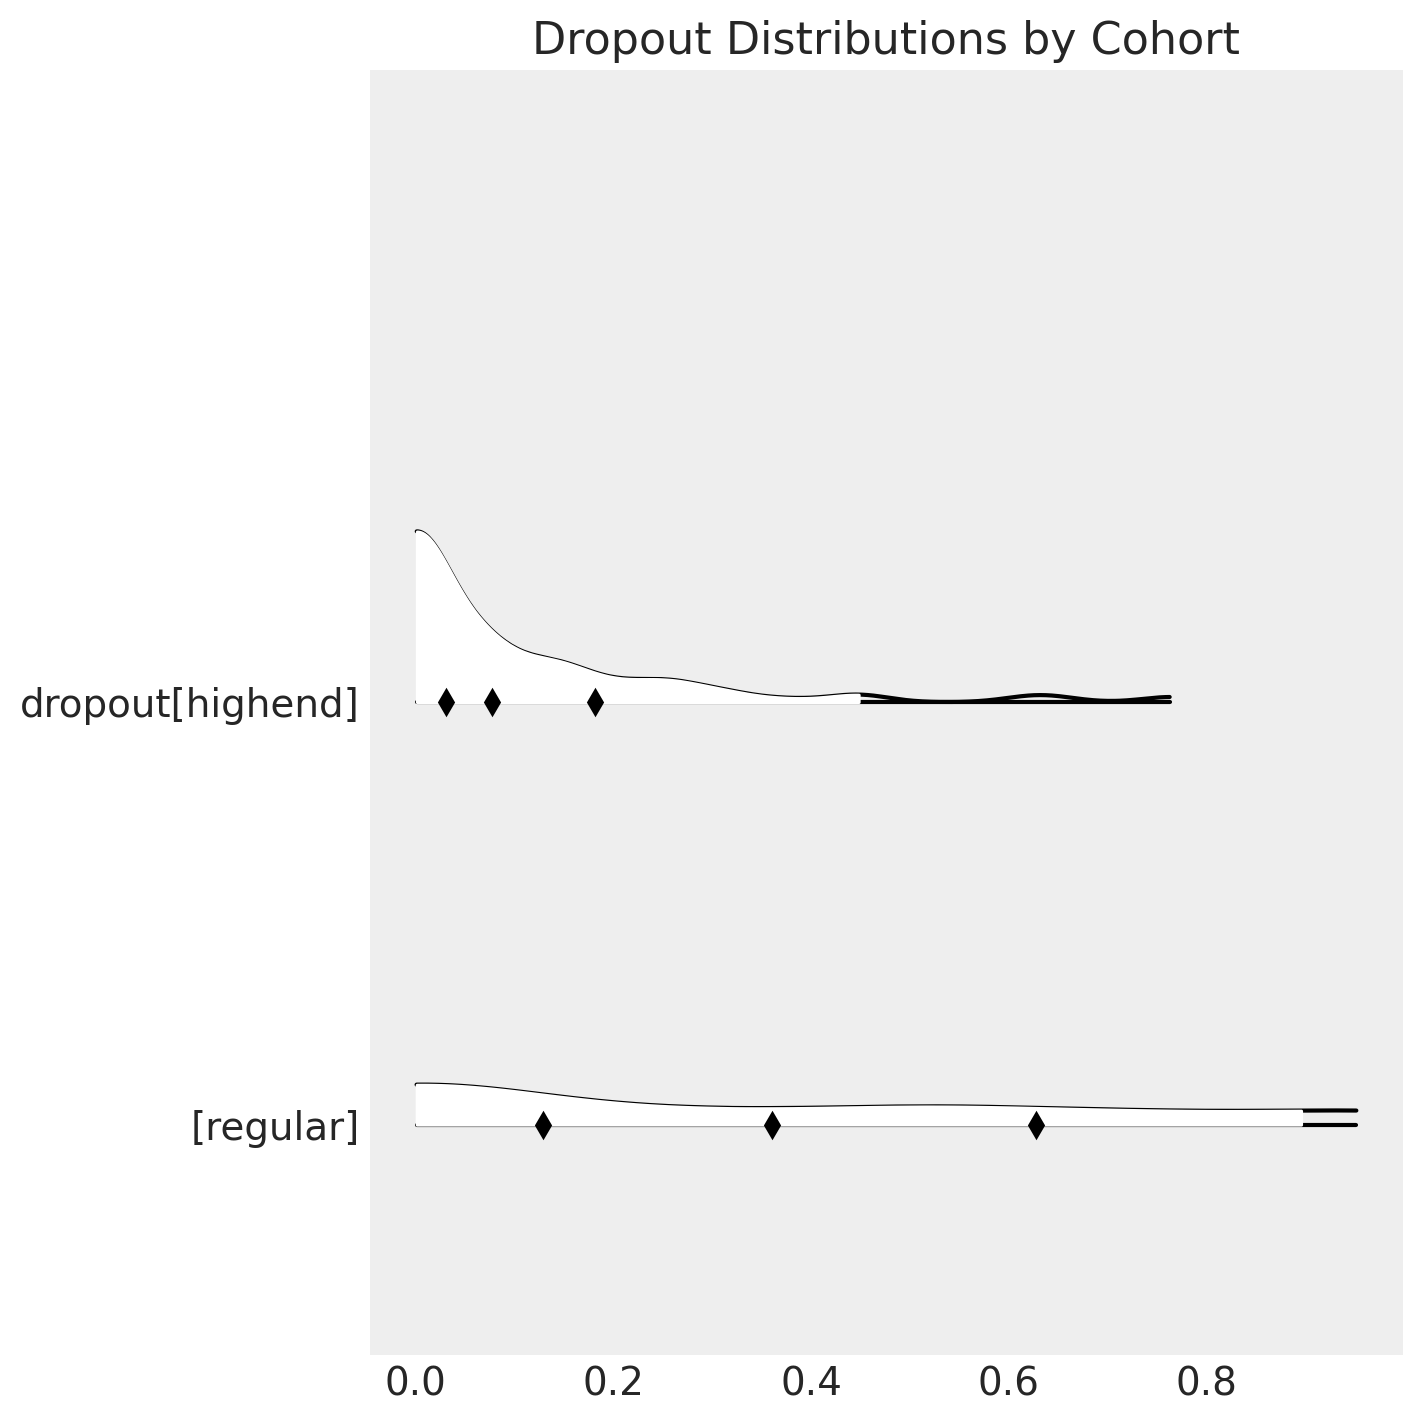

In [67]:
# Extract alpha and beta from fit results
alpha = sbg.fit_result["alpha"]
beta = sbg.fit_result["beta"]

# Generate 100 random samples from Beta distribution for each cohort
rng = np.random.default_rng(42)
n_samples = 100

cohorts = alpha.coords['cohort'].values
dropout_samples = np.array([
    rng.beta(
        alpha.sel(cohort=c).values.item(),  # Use .item() to get scalar
        beta.sel(cohort=c).values.item(),   # Use .item() to get scalar
        size=n_samples
    )
    for c in cohorts
]).T  # Transpose to get (samples, cohorts) shape

# Create xarray DataArray with chain, draw, and cohort dimensions
# Reshape to add chain dimension (1 chain, n_samples draws)
dropout = xr.DataArray(
    dropout_samples[np.newaxis, :, :],  # Add chain dimension
    dims=("chain", "draw", "cohort"),
    coords={
        "chain": [0],
        "draw": np.arange(n_samples),
        "cohort": cohorts,
    },
    name="dropout",
)

# Convert to InferenceData
dropout_idata = az.convert_to_inference_data(dropout)

# Plot with arviz
axes = az.plot_forest(
    dropout_idata,
    kind='ridgeplot',
    combined=True,
    colors='white',
    ridgeplot_overlap=1,
    ridgeplot_truncate=False,
    ridgeplot_quantiles=[.25,.5,.75],
    figsize=(7,7),
)
axes[0].set_title("Dropout Distributions by Cohort")

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

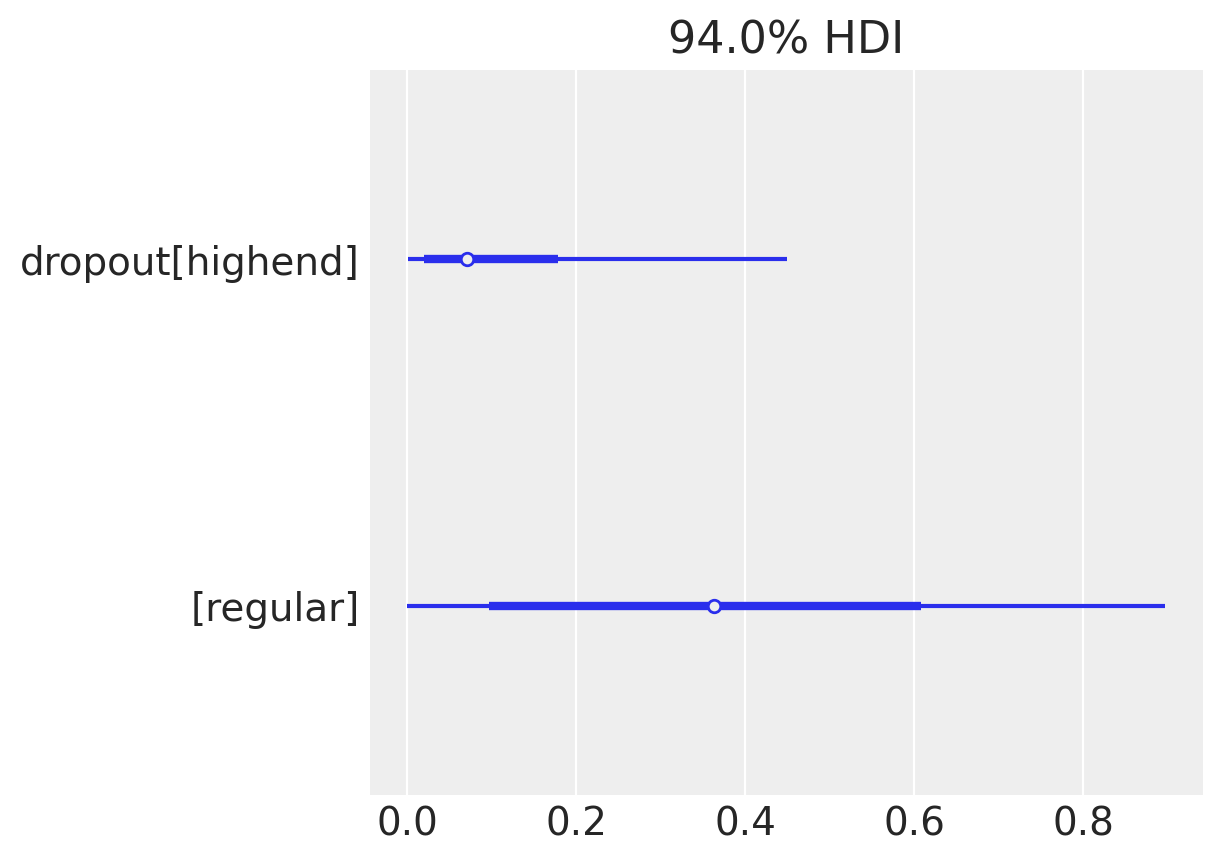

In [66]:
az.plot_forest(dropout_idata)

In [40]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc,pytensor

Last updated: Wed Nov 05 2025

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.4.0

pymc    : 5.25.1
pytensor: 2.31.7

pymc_extras   : 0.4.0
pytensor      : 2.31.7
pandas        : 2.3.1
pymc          : 5.25.1
arviz         : 0.22.0
matplotlib    : 3.10.3
numpy         : 2.2.6
pymc_marketing: 0.17.0
xarray        : 2025.7.1

Watermark: 2.5.0

